In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import os
import re
import math
import json
import numpy as np
from typing import Sequence, Tuple, Optional, Dict, List
import torch
import torch.nn as nn
import torch.nn.functional as F
import itertools as it

@torch.no_grad()
def save_grid_samples_with_bnet(
    *,
    G: nn.Module,
    regressors: Sequence[nn.Module],             # D regressors
    ranges: Sequence[Tuple[float, float]],       # [(a1,b1),...,(aD,bD)] after scaling
    ks: Sequence[int],                           # [k1,...,kD]
    bnet_state_path: str,
    out_dir: str,
    n_per_bin: int,
    # BNet / sampling
    z_dim: Optional[int] = None,
    k_householder: int = 6,
    r_z: float = 1.0,
    regressor_scales: Optional[Sequence[float]] = None,  # multiply each reg output
    # runtime
    device: Optional[torch.device] = None,
    batch_size: int = 512,
    max_batches: Optional[int] = None,           # safety cap; None = until all bins are full
    # what to save
    save_z: bool = True,
    save_w: bool = False,
    save_y: bool = True,
    prefix: str = "bin",
    verbose: bool = True,
    # sampling parameters
    truncation_psi: float = 1.0,
    lambda_I_reg: float = 1e-5,
) -> Dict[str, int]:
    """
    Vectorized binning for D regressors:
      - compute linear bin index for the whole batch
      - group by unique bins (one indexing per bin)
      - append up to the remaining quota for each bin in one go
      - save & flush bins immediately once full

    Resumes by skipping bins already saved to disk.
    """
    D = len(regressors)
    assert D >= 1, "Need at least one regressor."
    assert len(ranges) == D, f"len(ranges) must match number of regressors (got {len(ranges)} vs {D})."
    assert len(ks) == D, f"len(ks) must match number of regressors (got {len(ks)} vs {D})."
    ks = [int(x) for x in ks]
    total_bins = int(np.prod(ks))

    # scales: broadcast-friendly & forgiving
    if regressor_scales is None:
        regressor_scales = [1.0] * D
    elif len(regressor_scales) == 1:
        regressor_scales = [float(regressor_scales[0])] * D
    elif len(regressor_scales) != D:
        if verbose:
            print(f"[warn] regressor_scales has len={len(regressor_scales)} != D={D}; cycling values.")
        regressor_scales = list(it.islice(it.cycle(regressor_scales), D))
    regressor_scales = [float(s) for s in regressor_scales]

    os.makedirs(out_dir, exist_ok=True)
    device = device or next(G.parameters()).device
    z_dim = int(z_dim if z_dim is not None else getattr(G.mapping, "z_dim", None))
    assert z_dim is not None, "Could not infer z_dim; pass it explicitly."

    # ---- Load BNet (OrthoScale must exist in your environment) ----
    Bnet = OrthoScale(d=z_dim, k_householder=k_householder, device=device).to(device).eval()
    ckpt = torch.load(bnet_state_path, map_location=device)
    state = None
    if isinstance(ckpt, dict):
        for k in ["state_dict","bnet_state_dict","Bnet","Bnet_state_dict","model_state_dict"]:
            if k in ckpt and isinstance(ckpt[k], dict):
                state = ckpt[k]; break
        if state is None:
            state = ckpt
    missing, unexpected = Bnet.load_state_dict(state, strict=False)
    if verbose:
        print(f"[BNet] Loaded. missing={missing}, unexpected={unexpected}")

    G.eval()
    for r in regressors:
        r.to(device).eval()

    B = Bnet()
    B = B*(1-lambda_I_reg)+ lambda_I_reg*torch.eye(z_dim,device=device)
    # ---- Helpers ----
    def acg_sample(n: int) -> torch.Tensor:
        s = torch.randn(n, z_dim, device=device)
        u = s @ B.T
        x = u / (u.norm(dim=1, keepdim=True) + 1e-8)
        return r_z * x

    def file_for_idx(idx_tuple: Sequence[int]) -> str:
        # e.g., bin_3-0-7-1.npz
        return os.path.join(out_dir, f"{prefix}_" + "-".join(str(int(i)) for i in idx_tuple) + ".npz")

    def unravel_L(L: int) -> List[int]:
        return list(np.unravel_index(L, ks))  # row-major

    # precompute row-major strides: stride[d] = prod(ks[d+1:])
    strides = [int(np.prod(ks[d+1:])) for d in range(D)]
    strides_t = torch.tensor(strides, device=device)

    # ---- Resume: mark already completed bins ----
    done = np.zeros(ks, dtype=bool)  # shape (k1,...,kD)
    # Accept files named like: "{prefix}_i-j-...-m.npz"
    suffix = ".npz"
    for fname in os.listdir(out_dir):
        if not fname.startswith(f"{prefix}_") or not fname.endswith(suffix):
            continue
        core = fname[len(prefix) + 1 : -len(suffix)]
        parts = core.split("-")
        if not all(p.isdigit() for p in parts):
            continue
        if len(parts) != D:
            continue
        idxs = list(map(int, parts))
        if all(0 <= idxs[d] < ks[d] for d in range(D)):
            done[tuple(idxs)] = True

    done_flat_np = done.reshape(-1)                  # (B,)
    counts_flat = np.zeros_like(done_flat_np, dtype=np.int32)

    # torch view of "done" on device (for quick masking)
    done_flat_t = torch.from_numpy(done_flat_np).to(device=device)

    buffers: Dict[int, Dict[str, list]] = {}        # key: linear L; values: lists of CPU numpy chunks

    def ensure_buf(L: int):
        if L not in buffers:
            buffers[L] = {"z": [], "w": [], "y": []}

    def maybe_write_and_close(L: int):
        # Concatenate CPU chunks and write exactly n_per_bin rows
        idx_tuple = unravel_L(L)
        payload = {}
        meta = {
            "bin_index": [int(i) for i in idx_tuple],
            "ranges": [tuple(map(float, ab)) for ab in ranges],
            "ks": [int(x) for x in ks],
            "n_per_bin": int(n_per_bin),
            "regressor_scales": [float(s) for s in regressor_scales],
            "save_z": bool(save_z),
            "save_w": bool(save_w),
            "save_y": bool(save_y),
        }
        buf = buffers.get(L, None)
        if buf is None:
            return
        if save_z and buf["z"]:
            z_cat = np.concatenate(buf["z"], axis=0) if len(buf["z"]) > 1 else buf["z"][0]
            payload["z"] = z_cat[:n_per_bin]
        if save_w and buf["w"]:
            w_cat = np.concatenate(buf["w"], axis=0) if len(buf["w"]) > 1 else buf["w"][0]
            payload["w"] = w_cat[:n_per_bin]
        if save_y and buf["y"]:
            y_cat = np.concatenate(buf["y"], axis=0) if len(buf["y"]) > 1 else buf["y"][0]
            payload["y"] = y_cat[:n_per_bin]
        payload["meta_json"] = np.frombuffer(json.dumps(meta).encode("utf-8"), dtype=np.uint8)

        out_path = file_for_idx(idx_tuple)
        np.savez_compressed(out_path, **payload)

        done_flat_np[L] = True
        counts_flat[L] = n_per_bin
        done_flat_t[L] = True  # reflect on device for subsequent batches
        buffers.pop(L, None)
        if verbose:
            print(f"[bin saved] {tuple(idx_tuple)} -> {out_path}")

    if verbose:
        print(f"[init] grid={'x'.join(map(str, ks))} ({total_bins} bins); already done: {int(done_flat_np.sum())}")
        print(f"[init] target per-bin n={n_per_bin}; batch_size={batch_size}")

    # ---- Main loop (vectorized within each batch) ----
    batches = 0
    while True:
        if int(done_flat_np.sum()) == total_bins:
            break
        if max_batches is not None and batches >= max_batches:
            if verbose:
                print("[stop] Reached max_batches cap.")
            break

        batches += 1

        # 1) Sample & evaluate once per batch
        z = acg_sample(batch_size)                         # [B, z_dim]
        ws = G.mapping(z, None, truncation_psi=truncation_psi)                            # [B, num_ws, w_dim]
        w = ws[:, 0]                                       # [B, w_dim]

        # Evaluate all regressors -> list of [B] tensors
        y_list = []
        for r, s in zip(regressors, regressor_scales):
            y_list.append((r(w).view(-1) * float(s)))
        print([(y_list[i].min(),y_list[i].max()) for i in range(len(y_list))])
        # 2) Compute bin indices for all samples (vectorized)
        eps = 1e-8
        Bsz = z.shape[0]
        valid = torch.ones(Bsz, dtype=torch.bool, device=device)
        idxs_per_dim: List[torch.Tensor] = []
        for d in range(D):
            a, b = ranges[d]
            yd = y_list[d]
            valid &= (yd >= a) & (yd <= b)
        if not valid.any():
            if verbose and (batches % 10 == 0):
                print(f"[progress] batches={batches}  bins_done={int(done_flat_np.sum())}/{total_bins} "
                      f"({100.0*done_flat_np.sum()/total_bins:.1f}%)")
            continue

        for d in range(D):
            a, b = ranges[d]
            yd = y_list[d]
            kd = ks[d]
            idx_d = torch.clamp(((yd - a) / (b - a + eps) * kd).floor().long(), 0, kd - 1)
            idxs_per_dim.append(idx_d)

        # Linearize indices with row-major strides
        L = torch.zeros(Bsz, dtype=torch.long, device=device)
        for d in range(D):
            L += idxs_per_dim[d] * strides_t[d]

        # Exclude bins already completed (on device)
        flags = done_flat_t.index_select(0, L)              # [B] bool
        keep_mask = valid & (~flags)
        if not keep_mask.any():
            if verbose and (batches % 10 == 0):
                print(f"[progress] batches={batches}  bins_done={int(done_flat_np.sum())}/{total_bins} "
                      f"({100.0*done_flat_np.sum()/total_bins:.1f}%)")
            continue

        idx_keep = torch.nonzero(keep_mask, as_tuple=False).squeeze(1)  # [B_keep]
        L_keep = L.index_select(0, idx_keep)                            # [B_keep]

        # 3) Group by unique bins in this batch (one indexing per bin)
        uniq_L, inv, counts_in_batch = torch.unique(L_keep, return_inverse=True, return_counts=True, sorted=False)
        order = torch.argsort(inv)                                      # positions grouped by bin
        counts_cpu = counts_in_batch.cpu().numpy()
        offsets = np.concatenate([[0], np.cumsum(counts_cpu[:-1])]) if counts_cpu.size > 0 else np.array([0])

        # 4) Process each bin once (vectorized slice)
        for g in range(uniq_L.numel()):
            Lg = int(uniq_L[g].item())
            if done_flat_np[Lg]:
                continue  # may have been completed earlier in this batch

            cnt = int(counts_cpu[g])
            off = int(offsets[g])
            seg = order[off:off + cnt]                     # positions within idx_keep
            take_idx_all = idx_keep.index_select(0, seg)   # [cnt]

            need = int(n_per_bin) - int(counts_flat[Lg])
            if need <= 0:
                done_flat_np[Lg] = True
                done_flat_t[Lg] = True
                continue

            take = min(cnt, need)
            take_idx = take_idx_all[:take]                 # [take]

            # Slice once per tensor for this bin
            if save_z:
                z_chunk = z.index_select(0, take_idx).detach().cpu().numpy()
            if save_w:
                w_chunk = w.index_select(0, take_idx).detach().cpu().numpy()
            if save_y:
                y_stack = torch.stack([yd.index_select(0, take_idx) for yd in y_list], dim=1)
                y_chunk = y_stack.detach().cpu().numpy()

            ensure_buf(Lg)
            buf = buffers[Lg]
            if save_z: buf["z"].append(z_chunk)
            if save_w: buf["w"].append(w_chunk)
            if save_y: buf["y"].append(y_chunk)
            counts_flat[Lg] += take

            # If full, write and flush immediately (and mark done on CPU+GPU views)
            if counts_flat[Lg] >= n_per_bin:
                maybe_write_and_close(Lg)

        if verbose and (batches % 10 == 0):
            done_now = int(done_flat_np.sum())
            print(f"[progress] batches={batches}  bins_done={done_now}/{total_bins} ({100.0*done_now/total_bins:.1f}%)")

    summary = {
        "bins_total": int(total_bins),
        "bins_completed": int(done_flat_np.sum()),
        "samples_written": int(done_flat_np.sum()) * int(n_per_bin),
        "batches_run": int(batches),
    }
    if verbose:
        print(f"[done] {summary}")
    return summary

In [3]:
# === Enhanced version with W-space covariance diversity, CPU-only covariance every N steps,
#     and orthogonality/subspace-coverage regularization. ===

from __future__ import annotations

import numpy as np
import threading
from concurrent.futures import ThreadPoolExecutor, Future
from typing import Any, Dict, Optional, Tuple

import plotly.graph_objects as go
from plotly.subplots import make_subplots
from IPython.display import display

import torch
import torch.nn as nn
import torch.nn.functional as F

from PIL import Image


# -----------------------------
# Helper: Orthogonal-Scale map B via Householder + diag(scales)
# -----------------------------
class OrthoScale(nn.Module):
    """
    B = Q * diag(exp(log_sigma)), with Q orthogonal from product of Householder reflections.
    We enforce mean(log_sigma) = 0 each forward to fix global scale (ACG invariance).
    """
    def __init__(self, d: int, k_householder: int = 4, dtype=torch.float32, device: Optional[torch.device] = None):
        super().__init__()
        self.d = d
        self.k = k_householder
        self.v = nn.Parameter(torch.randn(k_householder, d, dtype=dtype, device=device) * 0.01)
        self.log_sigma = nn.Parameter(torch.zeros(d, dtype=dtype, device=device))

    def _householder_Q(self) -> torch.Tensor:
        d, k = self.d, self.k
        I = torch.eye(d, device=self.v.device, dtype=self.v.dtype)
        Q = I
        for i in range(k):
            v = self.v[i].unsqueeze(1)                              # [d,1]
            v = v / (v.norm(dim=0, keepdim=True) + 1e-8)           # normalize
            H = I - 2.0 * (v @ v.transpose(0,1))                   # [d,d]
            Q = H @ Q
        return Q

    def forward(self) -> torch.Tensor:
        Q = self._householder_Q()
        log_sigma = self.log_sigma - self.log_sigma.mean()         # fix global scale
        S = torch.diag(log_sigma.exp())
        B = Q @ S
        return B

In [4]:
scrambled = r"V\4Y::"  # raw string to keep backslash literal
special = 3

def unscramble(s: str, special_number: int) -> str:
    return ''.join(
        chr(ord(c) - special_number)
        for c in reversed(s)
    )

result = unscramble(scrambled, special)
print(result)

77V1YS


In [5]:
#@title init
import io
import os, time
import pickle
import shutil
import numpy as np
# os.environ['PYTORCH_ENABLE_MPS_FALLBACK'] = '1'
import torch
import torch.nn.functional as F
import sys
import shutil
import torchvision.transforms.functional as TF
from torchvision.transforms import Compose, Resize, ToTensor, Normalize
from sklearn.model_selection import train_test_split
import csv
import numpy as np
import pandas as pd
import PIL.Image
from PIL import Image, ImageDraw
import IPython.display
import matplotlib.pyplot as plt
from pathlib import Path
from tqdm import tqdm
from ipywidgets import interact, Button, FloatSlider, Layout
import sys

import torch
import torch.nn.functional as F
import requests
import torchvision.transforms as transforms
import torchvision.transforms.functional as TF
import copy
import unicodedata
import re
from PIL import Image
from tqdm.notebook import tqdm
from torchvision.transforms import Compose, Resize, ToTensor, Normalize
from IPython.display import display
from einops import rearrange
from time import perf_counter
# !pip install einops plotly tqdm scikit-learn x_transformers 
# df = pd.read_hdf('coords_wlosses.h5')





df = pd.read_csv('/Users/adamsobieszek/PycharmProjects/psychGAN/content/coords_wlosses.csv')

In [6]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
from pathlib import Path
from torchvision.transforms import Compose, Resize
import torchvision.transforms.functional as TF
from typing import List, Dict, Union, Tuple
%cd /Users/adamsobieszek/PycharmProjects/_manipy/
# Assuming the existence of these from a library like torchdyn
os.environ['PATH'] = os.environ['PATH']+':/opt/anaconda3/envs/manip311/'
print(os.environ['PATH'])


from manipy.models.flow_models import VectorFieldTransformer, RatingODE
from manipy.models.layers import EnsembleRegressor, MeanRegressor
from manipy.models.rating_models import AlphaBetaRegressor

final_models_path = "/Users/adamsobieszek/PycharmProjects/psychGAN/content/"


import locale

locale.getpreferredencoding = lambda: "UTF-8"
device= "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"




class From100To1(nn.Module):
  def __init__(self, model):
     super().__init__()
     self.model = model

  def forward(self, x):
     return self.model(x)/100

# del control_models
if not "control_models" in dir():
  # if not os.path.exists("final_models.zip"):
  #   !gdown 1pPjOd-mx-d-vOw1QR_lpJoJmLAGdkI3W
  #   !unzip final_models.zip
  #   !unzip final_models.zip
  control_names = ['trustworthy','dominant', 'gender', 'age', 'white', 'happy']
  control_models = [EnsembleRegressor([MeanRegressor(512,1) for _ in range(8)], model_kwargs={}).to(device) for label in control_names]
  for m,l in zip(control_models,control_names):
    m.load_state_dict(torch.load(f"{final_models_path}/final_models/ensemble_{l}.pt", map_location=torch.device("mps")))
    m.eval()
  ALL_MODELS = {**{l:From100To1(m) for l,m in zip(control_names,control_models)}}


# G, face_w, device = setup_stylegan()
# G, face_w, device = setup_stylegan()
sys.path.append('/Users/adamsobieszek/PycharmProjects/_manipy')
from mapping_network import *

DEVICE = torch.device('mps')

mapping = MappingNetwork(512,0,512,18).to(DEVICE)
mapping.load_state_dict(torch.load("/Users/adamsobieszek/PycharmProjects/_manipy/mapping_network/map (1).pt", weights_only=True, map_location=DEVICE))
class MockGenerator(nn.Module):
    mapping = mapping


G = MockGenerator().eval().to(DEVICE)
G = torch.compile(G, )
start_time = time.time()
print(G.mapping.w_avg.shape)
all_z = torch.randn([1, G.mapping.z_dim], device=device)
face_w = G.mapping(all_z, None, truncation_psi=0.5)
dim = "trustworthy"


w_avg = G.mapping.w_avg

ALL_MODELS['trustworthy'](w_avg.reshape(1,512).to(device))



sys.path.append('/Users/adamsobieszek/PycharmProjects/psychGAN/content/psychGAN/stylegan3')
with open('/Users/adamsobieszek/PycharmProjects/psychGAN/stylegan2-ffhq-1024x1024.pkl', 'rb') as fp:
    G = pickle.load(fp)['G_ema'].to(device)
with open('/Users/adamsobieszek/PycharmProjects/psychGAN/stylegan2-ffhq-1024x1024.pkl', 'rb') as fp:

    D = pickle.load(fp)['D'].to(device)

# Compute the average latent vector
all_z = torch.randn([1, G.mapping.z_dim], device=device)
face_w = G.mapping(all_z, None, truncation_psi=0.5)


/Users/adamsobieszek/PycharmProjects/_manipy
/opt/anaconda3/envs/manip311/bin:/opt/homebrew/Cellar/openjdk@21/21.0.8/libexec/openjdk.jdk/Contents/Home/bin:/Users/adamsobieszek/.cargo/bin:/Users/adamsobieszek/.local/bin:/Users/adamsobieszek/Library/Android/sdk/platform-tools:/Users/adamsobieszek/Library/Android/sdk/emulator:/Users/adamsobieszek/Library/Android/sdk/cmdline-tools/latest/bin:/Users/adamsobieszek/google-cloud-sdk/bin:/opt/homebrew/bin:/opt/homebrew/sbin:/opt/anaconda3/envs/manip311/bin:/opt/anaconda3/condabin:/usr/local/bin:/System/Cryptexes/App/usr/bin:/usr/bin:/bin:/usr/sbin:/sbin:/var/run/com.apple.security.cryptexd/codex.system/bootstrap/usr/local/bin:/var/run/com.apple.security.cryptexd/codex.system/bootstrap/usr/bin:/var/run/com.apple.security.cryptexd/codex.system/bootstrap/usr/appleinternal/bin:/Library/Apple/usr/bin:/usr/local/MacGPG2/bin:/Library/TeX/texbin:/opt/anaconda3/envs/manip311/
torch.Size([512])


In [7]:
from manipy.models.rating_models import load_trust_model_ensemble

def get_trust_model_fn(dim, device):
    """
    Loads the trust model and returns a simple function for its forward pass.
    This function will serve as our f(x).
    """
    print("Loading pre-trained trust model to be used as f(w)...")
    trust_model = load_trust_model_ensemble(
        dim_name=dim,
        ensemble_size=8,
        checkpoint_dir='/Users/adamsobieszek/PycharmProjects/psychGAN/best_models/',
        device=device,
        w_avg=G.mapping.w_avg,
    )
    trust_model.eval()

    
    f_func = lambda w: trust_model(w, output='mean').squeeze(-1)#*([(m>18)*(m<30) for m in [ALL_MODELS['age'](w)*100]][0]).squeeze(-1)

    
    
    return f_func, trust_model


# class f_module(torch.nn.Module):
#     def __init__(self, f_potential_func_ref, kwargs={}):
#         super(f_module, self).__init__()
#         self.f_potential_func = f_potential_func_ref
#         self.kwargs = kwargs
#     def forward(self, x):
#         return self.f_potential_func(x, **self.kwargs)


# f, ALL_MODELS['attractive'] = get_trust_model_fn('attractive', 'mps')

# attractive_model = f_module(f)

import re
from pathlib import Path
import torch
from torch import nn

class SmallMeanRegressor(nn.Module):
    def __init__(self, latent_dim=512, target_dim=1, encoder=lambda x: x-w_avg):
        super().__init__()
        self.network = nn.Sequential(
            nn.Linear(latent_dim, 1024),
            nn.ReLU(),
            nn.Linear(1024, 1024),
            nn.ReLU(),
            nn.Dropout(0.1),

            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Dropout(0.1),

            nn.Linear(512, target_dim),
            # nn.Sigmoid(),
        )
        self.encoder = encoder
        if isinstance(encoder, nn.Module):
            self.encoder = encoder.to(device).eval().requires_grad_(False)

    def forward(self, x):
        return self.network(self.encoder(x))
    


class EnsembleMeanModel(nn.Module):
    """
    Simple ensemble that averages the predictions of multiple members.
    Assumes each member returns a tensor shaped like the base model output
    (e.g., [B, 1] for SmallMeanRegressor).
    """
    def __init__(self, members: list[nn.Module]):
        super().__init__()
        self.members = nn.ModuleList(members)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # Average raw model outputs (SmallMeanRegressor already outputs means in [0,1])
        outs = [m(x) for m in self.members]
        return torch.mean(torch.sigmoid(torch.stack(outs, dim=0)), dim=0)

def _natural_fold_sort_key(p: str) -> int:
    """Extracts the fold number for stable sorting."""
    m = re.search(r"_fold(\d+)\.pt$", str(p))
    return int(m.group(1)) if m else 10**9

def load_transfer_ensemble(name: str,
                           save_dir: str = "transfer-learning2/transfer",
                           map_location=None) -> nn.Module:
    """
    Load all folds for a transfer run (e.g., name='src_to_tgt') and return an
    ensemble model that averages their predictions.

    Looks first in metrics JSON for exact fold paths; falls back to globbing.
    """
    # Resolve device
    dev = globals().get("device", torch.device("cuda" if torch.cuda.is_available() else "cpu"))
    if map_location is None:
        map_location = dev

    # Try to reuse the repo's cached metrics (preferred: preserves exact fold order)
    paths = []
    # Fallback: glob weights from disk if metrics are missing/outdated
    if not paths:
        paths = sorted(
            [str(p) for p in Path(save_dir).glob(f"{name}_fold*.pt")],
            key=_natural_fold_sort_key
        )

    if not paths:
        raise FileNotFoundError(
            f"No fold weights found for '{name}'. "
            f"Expected files like {Path(save_dir) / (name + '_fold0.pt')}"
        )

    # Build members
    members = []
    for p in paths:
        m = SmallMeanRegressor().to(dev)
        sd = torch.load(p, map_location=map_location)
        m.load_state_dict(sd)
        m.eval()
        for param in m.parameters():
            param.requires_grad = False
        members.append(m)

    # Return an eval-ready ensemble on the right device
    ensemble = EnsembleMeanModel(members).to(dev).eval()
    return ensemble


with torch.no_grad():
    model_path = '/Users/adamsobieszek/PycharmProjects/psychGAN/transfer-learning2/initial'
    # warm = load_transfer_ensemble("warm",
    #                        save_dir=model_path)  # example: "src_to_tgt"
    # competent = load_transfer_ensemble("competent",
    #                        save_dir=model_path)  # example: "src_to_tgt"
    # ws = G.mapping(torch.randn(50_000, 512).to(device), None, truncation_psi=1.0)
    # ws_warm = warm(ws[:,0])
    # ws_competent = competent(ws[:,0])



    # plt.scatter(torch.sigmoid(ws_warm).cpu().numpy()[:, 0], torch.sigmoid(ws_competent).cpu().numpy()[:, 0], alpha=0.1)
    # plt.show()

for dim in ['warm','competent']:
    ALL_MODELS[dim]=load_transfer_ensemble(dim,
                           save_dir=model_path)




In [8]:
def _sample_z(bnet, n: int) -> Tuple[torch.Tensor, torch.Tensor]:
    s = torch.randn(n, self.z_dim, device=self.device)
    B = bnet()
    u = s @ B.T
    x = u / (u.norm(dim=1, keepdim=True) + 1e-8)
    z = self.r_z * x
    return z, u

def _forward_batch(self, n: int) -> Dict[str, torch.Tensor]:
    z, u = _sample_z(n)
    ws = G.mapping(z, None)
    w = ws[:, 0]
    t = (regressor(w).view(-1) * regressor_scale)
    return {"z": z, "u": u, "x": z / (self.r_z + 1e-8), "t": t, "w": w}

# B = torch.load("adult_age_warm_comp_B.pt")

# Save age bin images

In [9]:
# with torch.no_grad():
#     save_grid_samples_with_bnet(
#         G=G,
#         regressors = [ALL_MODELS['age'], ALL_MODELS['warm'], ALL_MODELS['competent'], ALL_MODELS['gender']],             # exactly 3 regressors (y1,y2,y3)
#         ranges= [(25,65),(20,75),(65,78),(0,100)],       # [(a1,b1),(a2,b2),(a3,b3)] in the units AFTER scaling
#         ks= [10,  5, 3, 2],                           # [k1,k2,k3]
#         bnet_state_path='/Users/adamsobieszek/PycharmProjects/_manipy/all_age_white_bnet2.pt',                        # torch checkpoint of OrthoScale
#         out_dir = "/Users/adamsobieszek/PycharmProjects/_manipy/age_oems/",
#         n_per_bin=400,
#         # BNet / sampling
#         z_dim=512,
#         k_householder=6,
#         r_z=1.0,
#         regressor_scales=[100]*4,  # multiply each reg output
#         # runtime
#         device="mps",
#         batch_size = 50_000,
#         max_batches=None,           # safety cap; None = until all bins are full
#         # what to save
#         save_z=True,
#         save_w=False,
#         save_y=True,
#         # file naming
#         prefix="bin",
#         verbose=True,
#         truncation_psi=0.7,
#         lambda_I_reg=1e-3,
#      )

In [10]:
import os
import re
import json
from dataclasses import dataclass
from typing import Iterable, Tuple, Union, List, Optional, Dict, Sequence
import numpy as np

# ---------- Types ----------
BinIdx = Tuple[int, ...]
BinLike = Union[int, BinIdx]
BinsArg = Union[BinLike, Iterable[BinLike]]

@dataclass
class BinInventory:
    out_dir: str
    prefix: str
    D: int
    ks: Tuple[int, ...]
    ranges: Optional[List[Tuple[float, float]]]  # None if not found in meta
    n_per_bin: Optional[int]
    save_z: Optional[bool]
    save_w: Optional[bool]
    save_y: Optional[bool]
    mapping: Dict[BinIdx, str]  # (i1,...,iD) -> filepath


# ---------- Helpers ----------
def _parse_indices_from_fname(fname: str, prefix: str) -> Optional[Tuple[int, ...]]:
    """
    Support two patterns:
      1) New:  f"{prefix}_3-0-7-1.npz" -> (3,0,7,1)  (D arbitrary)
      2) Old:  f"{prefix}_i3_j0_k7.npz"-> (3,0,7)     (D=3)
    """
    if not fname.endswith(".npz"):
        return None

    # New pattern
    m = re.match(rf"^{re.escape(prefix)}_([0-9]+(?:-[0-9]+)*)\.npz$", fname)
    if m:
        parts = m.group(1).split("-")
        return tuple(int(p) for p in parts)

    # Old 3D pattern
    m = re.match(rf"^{re.escape(prefix)}_i(\d+)_j(\d+)_k(\d+)\.npz$", fname)
    if m:
        return (int(m.group(1)), int(m.group(2)), int(m.group(3)))

    return None


def _unravel_linear(L: int, ks: Sequence[int]) -> Tuple[int, ...]:
    return tuple(np.unravel_index(L, ks))


def _normalize_bins(bins: BinsArg, ks: Sequence[int]) -> List[Tuple[int, ...]]:
    """Normalize an int (linear), a single tuple, or an iterable of either into a list of D-tuples."""
    D = len(ks)

    def to_tuple(b: BinLike) -> Tuple[int, ...]:
        if isinstance(b, (np.integer, int)):
            return _unravel_linear(int(b), ks)
        if isinstance(b, (tuple, list, np.ndarray)):
            t = tuple(int(x) for x in b)
            if len(t) != D:
                raise ValueError(f"Bin tuple length {len(t)} != D={D}: {t}")
            return t
        raise TypeError(f"Invalid bin spec: {b!r}")

    # Single item?
    if isinstance(bins, (np.integer, int, tuple, list, np.ndarray)):
        # Distinguish (single tuple) vs (list of tuples)
        if isinstance(bins, (tuple, list, np.ndarray)) and bins and isinstance(bins[0], (tuple, np.ndarray, int, np.integer)):
            # Example ambiguity: passing [ (0,0,0), (1,1,1) ] should go to the else branch below
            # We resolve by checking the nesting depth:
            first = bins[0]
            is_iter_of_bins = isinstance(first, (tuple, list, np.ndarray)) or (
                isinstance(first, (int, np.integer)) and len(bins) != D  
            )
            if is_iter_of_bins:
                # Looks like a sequence of bin-likes
                return [to_tuple(b) for b in bins]  # type: ignore
            # Otherwise treat as a single tuple
        return [to_tuple(bins)]  # type: ignore

    # Generic iterable
    return [to_tuple(b) for b in bins]  # type: ignore


def _safe_first(it):
    for x in it:
        return x
    return None


# ---------- Scanner ----------
def scan_bins(out_dir: str, prefix: str = "bin", verify_meta: bool = False) -> BinInventory:
    """
    Scan a folder to infer D (num regressors), ks (bins per dim), ranges (from meta),
    and build a mapping from index tuples to files.
    """
    files = os.listdir(out_dir)
    mapping: Dict[BinIdx, str] = {}
    D_seen: Optional[int] = None

    for fname in files:
        idx = _parse_indices_from_fname(fname, prefix)
        if idx is None:
            continue
        if D_seen is None:
            D_seen = len(idx)
        elif len(idx) != D_seen:
            raise ValueError(f"Inconsistent dimensionality in filenames: got {len(idx)} and {D_seen}.")
        mapping[idx] = os.path.join(out_dir, fname)

    if not mapping:
        raise FileNotFoundError(f"No bin files matching '{prefix}_*.npz' found in {out_dir}")

    D = int(D_seen)
    # ks from observed filenames (fallback if meta missing or inconsistent)
    ks_obs = tuple((max(idxs[d] for idxs in mapping.keys()) + 1) for d in range(D))

    # Try to pull meta from a few files
    meta_candidates = []
    for path in list(mapping.values())[: min(64, len(mapping))]:
        try:
            with np.load(path, allow_pickle=False) as data:
                if "meta_json" in data.files:
                    meta = json.loads(data["meta_json"].tobytes().decode("utf-8"))
                    meta_candidates.append(meta)
        except Exception:
            pass

    ranges: Optional[List[Tuple[float, float]]] = None
    ks_meta: Optional[Tuple[int, ...]] = None
    n_per_bin = save_z = save_w = save_y = None

    if meta_candidates:
        # Take the first as reference
        m0 = meta_candidates[0]
        if "ranges" in m0 and isinstance(m0["ranges"], (list, tuple)):
            ranges = [tuple(map(float, ab)) for ab in m0["ranges"]]
            if len(ranges) != D:
                # If mismatch, drop to None
                ranges = None
        if "ks" in m0 and isinstance(m0["ks"], (list, tuple)):
            ks_meta = tuple(int(x) for x in m0["ks"])
        n_per_bin = int(m0.get("n_per_bin")) if "n_per_bin" in m0 else None
        save_z = bool(m0.get("save_z")) if "save_z" in m0 else None
        save_w = bool(m0.get("save_w")) if "save_w" in m0 else None
        save_y = bool(m0.get("save_y")) if "save_y" in m0 else None

        if verify_meta:
            # Light consistency check across sampled files
            for m in meta_candidates[1:]:
                if "ks" in m and ks_meta is not None and tuple(m["ks"]) != ks_meta:
                    raise ValueError("Inconsistent 'ks' across meta_json files.")
                if "ranges" in m and ranges is not None and [tuple(x) for x in m["ranges"]] != ranges:
                    raise ValueError("Inconsistent 'ranges' across meta_json files.")

    ks = ks_meta if ks_meta is not None else ks_obs

    return BinInventory(
        out_dir=out_dir,
        prefix=prefix,
        D=D,
        ks=tuple(int(x) for x in ks),
        ranges=ranges,
        n_per_bin=n_per_bin,
        save_z=save_z,
        save_w=save_w,
        save_y=save_y,
        mapping=mapping,
    )


# ---------- Loader ----------
def load_bins(
    bins: BinsArg,
    *,
    out_dir: Optional[str] = None,
    prefix: str = "bin",
    inventory: Optional[BinInventory] = None,
    strict: bool = True,
    verify_meta: bool = False,
) -> Tuple[Optional[np.ndarray], Optional[np.ndarray], Optional[np.ndarray], BinInventory]:
    """
    Load one or more saved bins and concatenate their contents.

    Parameters
    ----------
    bins : int | (i1,...,iD) | iterable of those
        Bin(s) to load. Accepts linear index L or D-tuples.
    out_dir, prefix :
        Where to scan. Ignored if `inventory` is provided.
    inventory :
        Optional result of scan_bins(). If not provided, we scan now.
    strict : bool (default True)
        If True, raise if any requested bin file is missing or any of z/w/y
        is missing in one of the bins. If False, silently skip missing files
        and fields (returning None if a field is absent in all bins).
    verify_meta : bool (default False)
        If True, checks that 'n_per_bin' in meta matches the first dimension
        of arrays in each file.

    Returns
    -------
    (z, w, y, inventory)
        Concatenated arrays across bins (or None if a field wasn't present in any file),
        and the BinInventory discovered during the scan.
    """
    if inventory is None:
        if out_dir is None:
            raise ValueError("Provide either `inventory` or `out_dir`.")
        inventory = scan_bins(out_dir, prefix=prefix, verify_meta=verify_meta)

    ks = inventory.ks
    idx_list = _normalize_bins(bins, ks)

    z_parts: List[np.ndarray] = []
    w_parts: List[np.ndarray] = []
    y_parts: List[np.ndarray] = []

    for idx in idx_list:
        path = inventory.mapping.get(tuple(idx))
        if path is None:
            if strict:
                raise FileNotFoundError(f"Missing bin file for index {tuple(idx)}")
            continue

        with np.load(path, allow_pickle=False) as data:
            # Optional meta sanity checks
            if verify_meta and "meta_json" in data.files:
                try:
                    meta = json.loads(data["meta_json"].tobytes().decode("utf-8"))
                    n_per_bin = int(meta.get("n_per_bin", -1))
                except Exception:
                    n_per_bin = -1
                for key in ("z", "w", "y"):
                    if key in data.files and n_per_bin > -1:
                        if int(data[key].shape[0]) != n_per_bin:
                            raise ValueError(
                                f"{os.path.basename(path)}:{key} first dim {data[key].shape[0]} != n_per_bin {n_per_bin}"
                            )

            # Collect parts (some files may omit z/w/y depending on save_* flags)
            if "z" in data.files:
                z_parts.append(np.array(data["z"]))
            elif strict:
                raise KeyError(f"'z' not found in {path}")

            if "w" in data.files:
                w_parts.append(np.array(data["w"]))
            elif strict:
                raise KeyError(f"'w' not found in {path}")

            if "y" in data.files:
                y_parts.append(np.array(data["y"]))
            elif strict:
                raise KeyError(f"'y' not found in {path}")

    z = np.concatenate(z_parts, axis=0) if z_parts else None
    w = np.concatenate(w_parts, axis=0) if w_parts else None
    y = np.concatenate(y_parts, axis=0) if y_parts else None
    return z, w, y, inventory


# ---------- Convenience ----------
def list_all_bins(inventory: BinInventory) -> List[Tuple[int, ...]]:
    """All bins discovered by the scanner, sorted lexicographically."""
    return sorted(inventory.mapping.keys())


def expected_missing_bins(inventory: BinInventory) -> List[Tuple[int, ...]]:
    """
    If ks were found (either from meta or observed), list missing bins that are
    expected but not present on disk. If ks came only from observation, this is
    just the Cartesian product up to ks minus observed; may overestimate.
    """
    from itertools import product
    ks = inventory.ks
    want = set(product(*[range(k) for k in ks]))
    have = set(inventory.mapping.keys())
    return sorted(want - have)

In [11]:
# # Mixed:
# out_dir = "/Users/adamsobieszek/PycharmProjects/_manipy/new_comp_warm_bins/"
# prefix = "bin"

# # Scan once
# inv = scan_bins(out_dir, prefix=prefix, verify_meta=True)
# print("D =", inv.D)
# print("ks =", inv.ks)
# print("ranges =", inv.ranges)  # may be None if not found in meta

# # # Load by tuples
# z, w, y, _ = load_bins([*range(0,300)], inventory=inv, strict=False)
# y

In [29]:
import os
import math
from pathlib import Path
from typing import Dict, Optional, Sequence, Tuple, List

import numpy as np
import torch
from torchvision.io import write_jpeg, write_png
from torchvision.transforms.functional import to_pil_image

# assumes scan_bins, load_bins, list_all_bins are available from your snippet


@torch.no_grad()
def _select_diverse_rows(
    X: torch.Tensor,           # [M, D] (codes, e.g., w)
    k: int,
    method: str = "qr",        # "qr" or "greedy"
    ridge: float = 1e-6,       # used by greedy
) -> List[int]:
    """
    Return indices of k rows of X that are maximally 'spread out' for linear models.
    - 'qr': pivoted-QR on X^T (fast, max-volume heuristic)
    - 'greedy': D-optimal (max logdet) with Sherman–Morrison updates
    """
    M, D = X.shape
    k = min(k, M)
    if k <= 0:
        return []

    # standardize so each latent dim contributes comparably
    Xc = X - X.mean(dim=0, keepdim=True)
    Xs = Xc / (Xc.std(dim=0, keepdim=True) + 1e-8)

    if method == "qr":
        try:
            # pivoted QR on transpose -> selects rows (as pivot "columns" of X^T)
            # NOTE: torch returns pivots as 1-based indices in some versions; handle generically
            Q, R, piv = torch.linalg.qr(Xs.T, mode="reduced", pivot=True)  # type: ignore
            piv = piv.to(torch.long)
            # Convert to 0-based if needed
            if piv.min() == 1 and piv.max() == Xs.shape[0]:
                piv = piv - 1
            return piv[:k].tolist()
        except Exception:
            # fall back if QR with pivoting isn't available
            method = "greedy"

    # Greedy D-optimal: maximize logdet(X^T X) with ridge for stability
    d = Xs.shape[1]
    info_inv = torch.eye(d, device=Xs.device) / ridge  # (λI)^-1
    selected = []
    remaining = torch.ones(Xs.shape[0], dtype=torch.bool, device=Xs.device)

    for _ in range(k):
        Xr = Xs[remaining]                          # [R, d]
        if Xr.numel() == 0:
            break
        # marginal gain ~ log(1 + x^T M^{-1} x); equivalently rank by q = x^T M^{-1} x
        q = (Xr @ info_inv * Xr).sum(dim=1)         # [R]
        best_rel = int(torch.argmax(q).item())
        # map back to absolute index
        abs_idx = torch.arange(Xs.shape[0], device=Xs.device)[remaining][best_rel].item()
        selected.append(abs_idx)

        # SM update: M_inv <- M_inv - (M_inv x x^T M_inv) / (1 + x^T M_inv x)
        x = Xs[abs_idx : abs_idx + 1]               # [1, d]
        v = (x @ info_inv)                          # [1, d]
        denom = 1.0 + (v @ x.T).squeeze()           # scalar
        info_inv = info_inv - (v.T @ v) / denom     # [d, d]

        remaining[abs_idx] = False

    return selected

@torch.no_grad()
def generate_least_correlated_per_bin(
    *,
    G: torch.nn.Module,
    bins_dir: str,
    prefix: str = "bin",
    age_dim: int,
    gender_dim: int,
    n_select: int,
    out_dir: str,
    start_img_index: int = 0,
    gender_index_to_char: Dict[int, str] = None,   # e.g., {0:'f', 1:'m'}
    use_z_if_w_missing: bool = True,
    selection_method: str = "qr",                  # "qr" or "greedy"
    selection_ridge: float = 1e-6,
    # image save options
    save_fmt: str = "jpg",                         # "jpg", "png", or "webp"
    jpg_quality: int = 95,
    png_compression: int = 6,
    webp_quality: int = 90,
    webp_lossless: bool = False,
    out_size: Optional[int] = None,                # optional resize
    noise_mode: str = "const",
    batch_size: int = 64,
    device: Optional[torch.device] = None,
) -> Dict[str, int]:
    """
    For every bin file in `bins_dir`, pick n_select least-correlated latent codes
    (per bin), generate images, and save {idx}_{f|m}_{age}.jpg/.pt
    (Now uses a reusable generator/saver helper.)
    """
    device = device or next(G.parameters()).device
    G.eval()
    os.makedirs(out_dir, exist_ok=True)

    inventory = scan_bins(bins_dir, prefix=prefix, verify_meta=False)
    if gender_index_to_char is None:
        gender_index_to_char = {0: "f", 1: "m"}

    total_bins = 0
    bins_processed = 0
    images_written = 0
    global_idx = int(start_img_index)

    def age_label_for_idx(age_bin_idx: int) -> str:
        if inventory.ranges is not None and 0 <= age_dim < len(inventory.ranges):
            a, b = inventory.ranges[age_dim]
            k = inventory.ks[age_dim]
            center = a + (age_bin_idx + 0.5) * (b - a) / float(k)
            return str(int(round(center)))
        return str(int(age_bin_idx))

    # Iterate all bins (lexicographic)
    for idx_tuple in list_all_bins(inventory):
        print(idx_tuple)
        total_bins += 1
        global_idx = 0  # (kept as in original; if you want global running index, remove this reset)

        # Extract age/gender
        if max(age_dim, gender_dim) >= len(idx_tuple):
            continue
        age_bin = int(idx_tuple[age_dim])
        gender_bin = int(idx_tuple[gender_dim])
        gender_ch = gender_index_to_char.get(gender_bin, str(gender_bin))
        age_lab = age_label_for_idx(age_bin)

        # Load bin contents
        try:
            if True:
                coord_path = "/Users/adamsobieszek/PycharmProjects/_manipy/content/age_test_redo_selected/coords copy/"
                bin_filenames = [coord_path+f for f in os.listdir(coord_path) if f.endswith(f"{gender_ch}_{age_lab}.pt")]
                coord_all_path = "/Users/adamsobieszek/PycharmProjects/_manipy/content/age_test_redo_selected/coords_all/"
                bin_filenames_all = [coord_all_path+f for f in os.listdir(coord_all_path) if f.endswith(f"{gender_ch}_{age_lab}.pt")]
                
                w_np = torch.stack([torch.load(f, map_location='cpu')['w'] for f in bin_filenames])
                w_np = w_np.numpy()
                y_np = torch.tensor([torch.load(f, map_location='cpu')['age_int'] for f in bin_filenames]).reshape(-1,1)
                y_np = y_np.numpy()
                z_np = None
            else:
                z_np, w_np, y_np, _ = load_bins(
                    idx_tuple, inventory=inventory, strict=False, verify_meta=False
                )
        except Exception as e:
            print(e)
            continue

        # Resolve codes (prefer W; optionally map Z->W)
        code_key = None
        if w_np is not None and w_np.ndim == 2 and w_np.shape[0] > 0:
            codes = torch.from_numpy(w_np).float().to(device)
            code_key = "w"
        elif z_np is not None and z_np.ndim == 2 and z_np.shape[0] > 0:
            z = torch.from_numpy(z_np).float().to(device)
            # map z->w and take the first w (consistent with original)
            codes = G.mapping(z, None, truncation_psi=.72)[:, 0]
            y_np = ALL_MODELS['age'](codes).cpu().numpy()*100
            codes = codes[(y_np.astype(int) == int(age_lab)).reshape(-1)]
            code_key = "w"
        else:
            raise ValueError("No codes found")
            continue

        m = int(codes.shape[0])
        k = min(int(n_select), m)
        if k <= 0:
            continue

        # Select diverse subset indices
        if selection_method is not None:
            sel_indices = _select_diverse_rows(
                codes, k=k, method=selection_method, ridge=selection_ridge
            )
            if not sel_indices:
                continue
            sel_codes = codes[sel_indices]  # [k, d]
        else:
            sel_codes = codes

        # Build file stems and payloads (aligned to selection)
        names = []
        payloads = []
        for rank_in_bin, sel_i in enumerate(sel_indices):
            stem = f"{global_idx}_{gender_ch}_{age_lab}"
            names.append(stem)

            payload = {
                code_key: sel_codes[rank_in_bin].detach().cpu(),
                "bin_index": tuple(int(x) for x in idx_tuple),
                "age_bin": age_bin,
                "gender_bin": gender_bin,
                "age_label": age_lab,
                "gender_char": gender_ch,
                "sel_rank_in_bin": rank_in_bin,
            }
            if y_np is not None and 0 <= sel_i < len(y_np):
                payload["y"] = torch.from_numpy(y_np[sel_i]).clone()
            payloads.append(payload)

            global_idx += 1

        # Generate & save using the reusable helper
        written = generate_and_save_from_codes(
            G=G,
            codes=sel_codes,               # interpreted as W
            names=names,                   # stems without extension
            payloads=payloads,             # optional per-image .pt payloads
            out_dir=out_dir,
            save_fmt=save_fmt,
            jpg_quality=jpg_quality,
            png_compression=png_compression,
            webp_quality=webp_quality,
            webp_lossless=webp_lossless,
            out_size=out_size,
            noise_mode=noise_mode,
            batch_size=batch_size,
            device=device,
        )
        images_written += int(written)
        bins_processed += 1

    summary = {
        "bins_total_seen": int(total_bins),
        "bins_processed": int(bins_processed),
        "images_written": int(images_written),
        "start_img_index": int(start_img_index),
        "next_img_index": int(global_idx),
    }
    print(f"[done] {summary}")
    return summary

import os
from typing import List, Optional, Dict
import torch
import torch.nn.functional as F

# torchvision writers for jpg/png
try:
    from torchvision.io import write_jpeg, write_png
except Exception:
    write_jpeg = write_png = None

# PIL for WEBP (and as a fallback if torchvision writers unavailable)
from PIL import Image


@torch.no_grad()
def generate_and_save_from_codes(
    *,
    G: torch.nn.Module,
    codes: torch.Tensor,                     # [K, D] W-codes
    names: List[str] = None,                        # file stems (no extension)
    payloads: Optional[List[Dict]] = None,   # optional per-image metadata for .pt
    out_dir: str,
    save_fmt: str = "jpg",                   # "jpg" | "png" | "webp"
    jpg_quality: int = 80,
    png_compression: int = 6,
    webp_quality: int = 90,
    webp_lossless: bool = False,
    out_size: Optional[int] = None,
    noise_mode: str = "const",
    batch_size: int = 64,
    device: Optional[torch.device] = None,
) -> int:
    """
    Synthesizes images from W codes and saves images + optional .pt payloads.

    Returns:
        images_written (int)
    """
    # names = names or [f"sample_{i}" for i in range(codes.shape[0])]
    assert codes.ndim == 2, "codes must be [K, D] W-space tensors"
    K = int(codes.shape[0])
    assert K == len(names), "len(names) must match number of codes"
    if payloads is not None:
        assert len(payloads) == K, "len(payloads) must match number of codes"

    os.makedirs(out_dir, exist_ok=True)

    # Normalize save format
    fmt = str(save_fmt).lower()
    if fmt not in ("jpg", "jpeg", "png", "webp"):
        fmt = "png"  # safe default

    # Resolve device & generator setup
    device = device or next(G.parameters()).device
    G_was_training = G.training
    G.eval()

    # Prepare codes on device
    codes = codes.to(device).float()

    # StyleGAN: determine num_ws to expand W appropriately
    num_ws = int(getattr(getattr(G, "synthesis", G), "num_ws", 18))

    images_written = 0

    # Helper: save a single image tensor (C,H,W uint8) to path
    def _save_img_u8(chw_u8: torch.Tensor, path_no_ext: str):
        h, w = int(chw_u8.shape[1]), int(chw_u8.shape[2])
        ext = fmt if fmt != "jpeg" else "jpg"
        img_path = f"{path_no_ext}.{ext}"

        if fmt in ("jpg", "jpeg"):
            if write_jpeg is not None:
                write_jpeg(chw_u8.contiguous(), img_path, quality=int(jpg_quality))
            else:
                # Fallback via PIL
                Image.fromarray(chw_u8.permute(1, 2, 0).cpu().numpy()).save(
                    img_path, format="JPEG", quality=int(jpg_quality), optimize=True
                )
        elif fmt == "png":
            if write_png is not None:
                write_png(chw_u8.contiguous(), img_path, compression_level=int(png_compression))
            else:
                Image.fromarray(chw_u8.permute(1, 2, 0).cpu().numpy()).save(
                    img_path, format="PNG", compress_level=int(png_compression), optimize=True
                )
        elif fmt == "webp":
            # torchvision doesn't write WEBP; use PIL
            Image.fromarray(chw_u8.permute(1, 2, 0).cpu().numpy()).save(
                img_path,
                format="WEBP",
                quality=int(webp_quality),
                lossless=bool(webp_lossless),
                method=6,
                optimize=True,
            )
        else:
            # Default to PNG
            if write_png is not None:
                write_png(chw_u8.contiguous(), img_path, compression_level=int(png_compression))
            else:
                Image.fromarray(chw_u8.permute(1, 2, 0).cpu().numpy()).save(
                    img_path, format="PNG", compress_level=int(png_compression), optimize=True
                )

    # Batch loop
    for i in range(0, K, batch_size):
        batch_w = codes[i : i + batch_size]                                # [B, D]
        batch_w = (batch_w- w_avg.unsqueeze(0))*0.8+w_avg.unsqueeze(0)
        ws = batch_w.unsqueeze(1).repeat(1, num_ws, 1)                      # [B, num_ws, D]

        # Synthesize: StyleGAN outputs in [-1,1]
        imgs = G.synthesis(ws, noise_mode=noise_mode)                       # [B, C, H, W]
        imgs = torch.clamp((imgs + 1.0) * 0.5, 0.0, 1.0)                    # to [0,1]

        if out_size is not None:
            imgs = F.interpolate(imgs, size=(int(out_size), int(out_size)),
                                 mode="bilinear", align_corners=False)

        # Convert to uint8 on CPU once
        imgs_u8 = (imgs.detach().cpu() * 255.0).round().to(torch.uint8)     # [B, C, H, W]
        B = int(imgs_u8.shape[0])

        # Save each image and its payload
        for b in range(B):
            stem = names[i + b]
            base_path = os.path.join(out_dir, stem)

            # Save image
            _save_img_u8(imgs_u8[b], base_path)

            # Save payload if provided
            if payloads is not None:
                pt_path = f"{base_path}.pt"
                torch.save(payloads[i + b], pt_path)

            images_written += 1

    # Restore training mode if neededx  
    if G_was_training:
        G.train()

    return images_written
# cpath = '/Users/adamsobieszek/Downloads/content 2/drive/Shareddrives/[PsychGAN]/age_test_redo_additional/coords'
# c = []
# names = []
# for f in os.listdir(cpath):
#     try:
#         c.append(torch.load(cpath+"/"+f, map_location='cpu')['w'])
#         names.append(f)
#     except Exception as e:
#         print(f"Error loading {f}: {e}")
#         print(e)
# codes = torch.stack(c).to(device)
# summary = generate_and_save_from_codes(
#     G=G,
#     codes = torch.stack(c).to(device),
#     names = names,
#     out_dir = "/Users/adamsobieszek/PycharmProjects/_manipy/selected_age_additional3/",

#     save_fmt="jpg",
#     out_size=1024,           # optional resize
#     batch_size=10,
# )

In [30]:
# Minimal interactive/notebook-friendly POC for age-preserving traversal toward w_avg in W-space.
# Robust to environments without ipywidgets: if ipywidgets is unavailable,
# the code still defines all functions and provides a callable `run_static_demo(...)`.
#
# Assumptions in *your* notebook runtime (not this sandbox):
# - Variables `age_model`, `w_avg`, `G`, and `ws` are defined.
# - `G.synthesis(ws, noise_mode="const")` returns images in [-1, 1].
# - `ws[:4]` gives four starting latent codes. They may be shaped [4, D] or [4, num_ws, D].

import math
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

# ------------------------------
# Helpers
# ------------------------------

def _infer_device():
    """Prefer the device of w_avg; else fall back to G's device; else cpu."""
    dev = None
    if isinstance(globals().get("w_avg", None), torch.Tensor):
        dev = w_avg.device
    if dev is None and "G" in globals():
        try:
            dev = next(G.parameters()).device
        except Exception:
            dev = torch.device("cpu")
    if dev is None:
        dev = torch.device("cpu")
    return dev

def _normalize_ws_shape(ws_in: torch.Tensor):
    """
    Normalize various W shapes to:
      - w_single: (B, D) tensor to optimize
      - expand_for_gen: callable to expand (B,D) -> (B, num_ws, D) for synthesis
      - num_ws inferred from G or default 18.
    """
    assert isinstance(ws_in, torch.Tensor), "Expected `ws` to be a torch.Tensor"
    # If ws_in is (B, D): treat as single W to be broadcast across layers.
    # If ws_in is (B, num_ws, D): take the first as the single W for optimization (common trick).
    if ws_in.ndim == 2:
        w_single = ws_in
    elif ws_in.ndim == 3 and ws_in.shape[1] >= 1:
        w_single = ws_in[:, 0, :]
    else:
        raise ValueError("Unsupported ws shape. Expected (B,D) or (B,num_ws,D).")
    # Infer num_ws from G if possible
    num_ws = int(getattr(getattr(globals().get("G", object), "synthesis", object), "num_ws", 18))
    def expand_for_gen(w_bxd: torch.Tensor):
        return w_bxd.unsqueeze(1).repeat(1, num_ws, 1)
    return w_single, expand_for_gen, num_ws

@torch.no_grad()
def _synthesize_images(G, w_bxd: torch.Tensor, expand_for_gen, to_uint8=True):
    """
    Synthesizes a batch of images from a batch of (B, D) W vectors by repeating across layers.
    Returns float [0,1] if to_uint8=False, else uint8 (B, H, W, C).
    """
    ws_bxLxd = expand_for_gen(w_bxd)
    try:
        imgs = G.synthesis(ws_bxLxd, noise_mode="const")
    except TypeError:
        imgs = G.synthesis(ws_bxLxd)
    imgs = torch.clamp((imgs + 1.0) * 0.5, 0.0, 1.0)  # [-1,1] -> [0,1]
    if to_uint8:
        imgs8 = (imgs.detach().cpu() * 255.0).round().to(torch.uint8)  # (B,C,H,W)
        imgs8 = imgs8.permute(0, 2, 3, 1).contiguous()                # (B,H,W,C)
        return imgs8
    return imgs  # (B,3,H,W) float in [0,1]

def _ensure_vector_wavg(w_avg_tensor: torch.Tensor, D: int) -> torch.Tensor:
    """
    Ensure w_avg is a (D,) vector. If it's (num_ws, D) or (1, D), reduce to (D,).
    """
    if w_avg_tensor.ndim == 1:
        return w_avg_tensor
    if w_avg_tensor.ndim == 2:
        return w_avg_tensor.mean(dim=0)
    raise ValueError("Unsupported w_avg shape; expected (D,) or (num_ws,D).")

# ------------------------------
# Core optimization (POC)
# ------------------------------

def optimize_towards_wavg_with_age_penalty(
    ws_init: torch.Tensor,
    w_avg_vec: torch.Tensor,
    age_model,  # generic callable nn.Module
    steps: int = 100,
    step_size: float = 0.05,
    age_weight: float = 10.0,
    noise_scale: float = 0.0,
    stride: int = 5,
    rng_seed: int = 0,
    device=None,
):
    """
    Perform a simple optimization in W-space:
      minimize  L = ||w - w_avg||^2 + age_weight * (age(w) - age_0)^2
    Using plain gradient descent on w (parameters of age_model are frozen).

    Returns:
      snapshots: list of 5 tensors, each (B,D), representing progress along the path.
      history: dict with scalars for debugging (loss, age drift, dist to w_avg).
    """
    torch.manual_seed(int(rng_seed))
    device = device if device is not None else _infer_device()
    device = torch.device(device)

    ws = ws_init.to(device).detach().clone()
    B, D = ws.shape
    w_avg_vec = _ensure_vector_wavg(w_avg_vec.to(device), D)

    # Freeze age_model params (if any) while keeping autograd for inputs
    try:
        if isinstance(age_model, nn.Module):
            age_model.eval()
            for p in age_model.parameters():
                p.requires_grad_(False)
    except Exception:
        pass

    with torch.no_grad():
        age0 = age_model(ws).view(B)

    snapshots = [ws.detach().clone()]
    loss_hist, age_drift_hist, dist_hist = [], [], []

    # Ensure enough steps for 5 checkpoints
    min_steps = max(1, 4 * stride)
    steps = max(int(steps), min_steps)

    for t in range(1, steps + 1):
        ws = ws.detach().requires_grad_(True)
        pred_age = age_model(ws).view(B)

        dist_term = ((ws - w_avg_vec.unsqueeze(0)) ** 2).mean()
        age_pen   = ((pred_age - age0) ** 2).mean()
        loss = dist_term + age_weight * age_pen

        loss.backward()
        with torch.no_grad():
            grad = ws.grad
            step = -step_size * grad
            if noise_scale > 0.0:
                step = step + noise_scale * torch.randn_like(ws)
            ws = (ws + step).detach()

        # Logs
        loss_hist.append(float(loss.detach().cpu()))
        with torch.no_grad():
            age_drift = float(((pred_age - age0) ** 2).mean().sqrt().detach().cpu())
            wdist = float(((ws - w_avg_vec.unsqueeze(0)) ** 2).mean().sqrt().detach().cpu())
            age_drift_hist.append(age_drift)
            dist_hist.append(wdist)

        # Save up to 5 snapshots at multiples of `stride`
        if (t % stride == 0) and (len(snapshots) < 5):
            snapshots.append(ws.detach().clone())
        if len(snapshots) >= 5:
            break

    history = {
        "loss": np.array(loss_hist, dtype=np.float32),
        "age_drift_rmse": np.array(age_drift_hist, dtype=np.float32),
        "w_dist_rmse": np.array(dist_hist, dtype=np.float32),
    }
    return snapshots, history

# ------------------------------
# Visualization
# ------------------------------

def _render_grid(images_by_col, title_by_col=None):
    """
    images_by_col: list of length 5; each element is a (B,H,W,C) uint8 batch to show in a column.
    """
    cols = len(images_by_col)
    assert cols == 5, "Expecting exactly 5 progress columns."
    B = images_by_col[0].shape[0]
    fig, axes = plt.subplots(B, cols, figsize=(2.8*cols, 2.8*B))
    if B == 1:
        axes = np.expand_dims(axes, 0)
    if cols == 1:
        axes = np.expand_dims(axes, -1)

    for c in range(cols):
        imgs = images_by_col[c]
        for r in range(B):
            ax = axes[r, c]
            ax.imshow(imgs[r].numpy())
            ax.axis("off")
            if title_by_col is not None and r == 0:
                ax.set_title(title_by_col[c], fontsize=10)
    plt.tight_layout()
    plt.show()

def _run_demo(stride=5, steps=80, step_size=0.05, noise_scale=0.01, age_weight=10.0, rng_seed=0):
    device = _infer_device()
    assert "ws" in globals(), "Expected a global variable `ws` with latent codes."
    assert "G" in globals(),  "Expected a global variable `G` (generator)."
    assert "age_model" in globals(), "Expected a global variable `age_model`."
    assert "w_avg" in globals(), "Expected a global variable `w_avg`."

    ws4 = ws[:4]
    w_single, expand_for_gen, num_ws = _normalize_ws_shape(ws4)

    # Prepare w_avg vector
    D = w_single.shape[1]
    wav = _ensure_vector_wavg(w_avg, D)

    # Optimize with snapshots
    snaps, hist = optimize_towards_wavg_with_age_penalty(
        w_single, wav, age_model,
        steps=int(steps),
        step_size=float(step_size),
        age_weight=float(age_weight),
        noise_scale=float(noise_scale),
        stride=int(stride),
        rng_seed=int(rng_seed),
        device=device
    )

    # Synthesize 5 columns (each column is a batch of 4 images)
    cols = []
    for i, wcol in enumerate(snaps):
        imgs = _synthesize_images(G, wcol.to(device), expand_for_gen, to_uint8=True)  # (B,H,W,C) uint8
        cols.append(imgs)

    titles = [f"step {i*stride}" for i in range(5)]
    _render_grid(cols, titles)

    print(f"Final loss: {hist['loss'][-1]:.4f} | Age drift RMSE: {hist['age_drift_rmse'][-1]:.4f} | W-dist RMSE: {hist['w_dist_rmse'][-1]:.4f}")

# ------------------------------
# Widget (if available) or a callable fallback
# ------------------------------
    """
    Synthesizes images from W codes and saves images + optional .pt payloads.

    Returns:
        images_written (int)
    """
    names = names or [f"sample_{i}" for i in range(codes.shape[0])]
    assert codes.ndim == 2, "codes must be [K, D] W-space tensors"
    K = int(codes.shape[0])
    assert K == len(names), "len(names) must match number of codes"
    if payloads is not None:
        assert len(payloads) == K, "len(payloads) must match number of codes"

    os.makedirs(out_dir, exist_ok=True)

    # Normalize save format
    fmt = str(save_fmt).lower()
    if fmt not in ("jpg", "jpeg", "png", "webp"):
        fmt = "png"  # safe default

    # Resolve device & generator setup
    device = device or next(G.parameters()).device
    G_was_training = G.training
    G.eval()

    # Prepare codes on device
    codes = codes.to(device).float()

    # StyleGAN: determine num_ws to expand W appropriately
    num_ws = int(getattr(getattr(G, "synthesis", G), "num_ws", 18))

    images_written = 0

    # Helper: save a single image tensor (C,H,W uint8) to path
    def _save_img_u8(chw_u8: torch.Tensor, path_no_ext: str):
        h, w = int(chw_u8.shape[1]), int(chw_u8.shape[2])
        ext = fmt if fmt != "jpeg" else "jpg"
        img_path = f"{path_no_ext}.{ext}"

        if fmt in ("jpg", "jpeg"):
            if write_jpeg is not None:
                write_jpeg(chw_u8.contiguous(), img_path, quality=int(jpg_quality))
            else:
                # Fallback via PIL
                Image.fromarray(chw_u8.permute(1, 2, 0).cpu().numpy()).save(
                    img_path, format="JPEG", quality=int(jpg_quality), optimize=True
                )
        elif fmt == "png":
            if write_png is not None:
                write_png(chw_u8.contiguous(), img_path, compression_level=int(png_compression))
            else:
                Image.fromarray(chw_u8.permute(1, 2, 0).cpu().numpy()).save(
                    img_path, format="PNG", compress_level=int(png_compression), optimize=True
                )
        elif fmt == "webp":
            # torchvision doesn't write WEBP; use PIL
            Image.fromarray(chw_u8.permute(1, 2, 0).cpu().numpy()).save(
                img_path,
                format="WEBP",
                quality=int(webp_quality),
                lossless=bool(webp_lossless),
                method=6,
                optimize=True,
            )
        else:
            # Default to PNG
            if write_png is not None:
                write_png(chw_u8.contiguous(), img_path, compression_level=int(png_compression))
            else:
                Image.fromarray(chw_u8.permute(1, 2, 0).cpu().numpy()).save(
                    img_path, format="PNG", compress_level=int(png_compression), optimize=True
                )

    # Batch loop
    for i in range(0, K, batch_size):
        batch_w = codes[i : i + batch_size]                                # [B, D]
        ws = batch_w.unsqueeze(1).repeat(1, num_ws, 1)                      # [B, num_ws, D]

        # Synthesize: StyleGAN outputs in [-1,1]
        imgs = G.synthesis(ws, noise_mode=noise_mode)                       # [B, C, H, W]
        imgs = torch.clamp((imgs + 1.0) * 0.5, 0.0, 1.0)                    # to [0,1]

        if out_size is not None:
            imgs = F.interpolate(imgs, size=(int(out_size), int(out_size)),
                                 mode="bilinear", align_corners=False)

        # Convert to uint8 on CPU once
        imgs_u8 = (imgs.detach().cpu() * 255.0).round().to(torch.uint8)     # [B, C, H, W]
        B = int(imgs_u8.shape[0])

        # Save each image and its payload
        for b in range(B):
            stem = names[i + b]
            base_path = os.path.join(out_dir, stem)

            # Save image
            _save_img_u8(imgs_u8[b], base_path)

            # Save payload if provided
            if payloads is not None:
                pt_path = f"{base_path}.pt"
                torch.save(payloads[i + b], pt_path)

            images_written += 1

    # Restore training mode if neededx  
    if G_was_training:
        G.train()

    return images_written
coord_path = '/Users/adamsobieszek/Downloads/content 2/drive/Shareddrives/[PsychGAN]/age_test_redo_additional/coords/'
bin_filenames = [coord_path+f for f in os.listdir(coord_path)]
ws = torch.stack([torch.load(f, map_location='cpu')['w'] for f in bin_filenames[:5]]).to(device)

_widgets_available = False
try:
    import ipywidgets as widgets
    _widgets_available = True
except ModuleNotFoundError:
    _widgets_available = False

if _widgets_available:
    stride_slider     = widgets.IntSlider(description="Stride", min=1, max=50, step=1, value=5, continuous_update=False)
    steps_slider      = widgets.IntSlider(description="Steps", min=20, max=400, step=5, value=80, continuous_update=False)
    step_size_slider  = widgets.FloatSlider(description="Step size", min=0.001, max=10.2, step=0.001, value=10.05, readout_format=".3f", continuous_update=False)
    noise_slider      = widgets.FloatSlider(description="Noise scale", min=0.0, max=0.1, step=0.001, value=0.01, readout_format=".3f", continuous_update=False)
    age_w_slider      = widgets.FloatSlider(description="Age weight", min=0.0, max=100.0, step=0.5, value=10.0, readout_format=".1f", continuous_update=False)
    seed_box          = widgets.IntText(description="Seed", value=0)

    controls = widgets.VBox([
        widgets.HTML("<h3>Age-preserving W traversal toward w_avg</h3>"),
        widgets.HBox([stride_slider, steps_slider, step_size_slider]),
        widgets.HBox([noise_slider, age_w_slider, seed_box])
    ])

    out = widgets.interactive_output(
        _run_demo,
        {
            "stride": stride_slider,
            "steps": steps_slider,
            "step_size": step_size_slider,
            "noise_scale": noise_slider,
            "age_weight": age_w_slider,
            "rng_seed": seed_box
        }
    )

    display(controls, out)
else:
    print(
        "ipywidgets is not installed in this environment.\n"
        "All functions have been defined. In your own notebook with `G`, `ws`, `age_model`, and `w_avg` available,\n"
        "either install ipywidgets for the interactive UI, or call this directly:\n\n"
        "  _run_demo(stride=5, steps=80, step_size=0.05, noise_scale=0.01, age_weight=10.0, rng_seed=0)\n\n"
        "Nothing was executed because required globals are not present in this sandbox."
    )

Output()

In [31]:

@torch.no_grad()
def generate_dataset(
    *,
    G: torch.nn.Module,
    num_samples: int,                        # Number of images to generate
    payloads: Optional[List[Dict]] = None,   # optional per-image metadata for .pt
    out_dir: str,
    save_fmt: str = "jpg",                   # "jpg" | "png" | "webp"
    jpg_quality: int = 80,
    png_compression: int = 6,
    webp_quality: int = 90,
    webp_lossless: bool = False,
    batch_size: int = 64,
    device: Optional[torch.device] = None,
    z_dim: int = 512,                        # Default z dimension for StyleGAN2/3
    truncation_psi: float = 1.5,
    noise_mode: str = "const",
) -> int:
    """
    Generates random z points, maps them to W with truncation, and saves images at 1024x1024 resolution.

    Returns:
        images_written (int)
    """
    import os
    import torch
    import torch.nn.functional as F
    from typing import Optional, List, Dict
    from PIL import Image
    names = [f"sample_{i}" for i in range(num_samples)]
    assert num_samples == len(names), "len(names) must match num_samples"
    if payloads is not None:
        assert len(payloads) == num_samples, "len(payloads) must match num_samples"

    os.makedirs(out_dir, exist_ok=True)

    # Normalize save format
    fmt = str(save_fmt).lower()
    if fmt not in ("jpg", "jpeg", "png", "webp"):
        fmt = "png"  # safe default

    # Resolve device & generator setup
    device = device or next(G.parameters()).device
    G_was_training = G.training
    G.eval()

    # StyleGAN: determine num_ws to expand W appropriately
    num_ws = int(getattr(getattr(G, "synthesis", G), "num_ws", 18))

    images_written = 0

    # Helper: save a single image tensor (C,H,W uint8) to path
    def _save_img_u8(chw_u8: torch.Tensor, path_no_ext: str):
        ext = fmt if fmt != "jpeg" else "jpg"
        img_path = f"{path_no_ext}.{ext}"

        if fmt in ("jpg", "jpeg"):
            if 'write_jpeg' in globals() and write_jpeg is not None:
                write_jpeg(chw_u8.contiguous(), img_path, quality=int(jpg_quality))
            else:
                Image.fromarray(chw_u8.permute(1, 2, 0).cpu().numpy()).save(
                    img_path, format="JPEG", quality=int(jpg_quality), optimize=True
                )
        elif fmt == "png":
            if 'write_png' in globals() and write_png is not None:
                write_png(chw_u8.contiguous(), img_path, compression_level=int(png_compression))
            else:
                Image.fromarray(chw_u8.permute(1, 2, 0).cpu().numpy()).save(
                    img_path, format="PNG", compress_level=int(png_compression), optimize=True
                )
        elif fmt == "webp":
            Image.fromarray(chw_u8.permute(1, 2, 0).cpu().numpy()).save(
                img_path,
                format="WEBP",
                quality=int(webp_quality),
                lossless=bool(webp_lossless),
                method=6,
                optimize=True,
            )
        else:
            if 'write_png' in globals() and write_png is not None:
                write_png(chw_u8.contiguous(), img_path, compression_level=int(png_compression))
            else:
                Image.fromarray(chw_u8.permute(1, 2, 0).cpu().numpy()).save(
                    img_path, format="PNG", compress_level=int(png_compression), optimize=True
                )

    # Get w_avg for truncation
    w_avg = getattr(G, "w_avg", None)
    if w_avg is None and hasattr(G, "mapping") and hasattr(G.mapping, "w_avg"):
        w_avg = G.mapping.w_avg
    if w_avg is None:
        # Fallback: compute w_avg from a large batch of z
        z_tmp = torch.randn(4096, z_dim, device=device)
        w_tmp = G.mapping(z_tmp, None)
        w_avg = w_tmp.mean(0, keepdim=True)
    else:
        w_avg = w_avg.to(device)

    # Batch loop
    for i in range(0, num_samples, batch_size):
        bsize = min(batch_size, num_samples - i)
        z = torch.randn(bsize, z_dim, device=device)
        # Map to W with truncation
        w = G.mapping(z, None)  # [B, num_ws, D] or [B, D]
        if w.ndim == 2:
            w = w.unsqueeze(1).repeat(1, num_ws, 1)
        elif w.shape[1] != num_ws:
            w = w[:, :num_ws, :]
        # Truncation
        w = w_avg + (w - w_avg) * truncation_psi

        # Synthesize: StyleGAN outputs in [-1,1]
        imgs = G.synthesis(w, noise_mode=noise_mode)  # [B, C, H, W]
        imgs = torch.clamp((imgs + 1.0) * 0.5, 0.0, 1.0)  # to [0,1]

        # Always save at 1024x1024
        if imgs.shape[-1] != 1024 or imgs.shape[-2] != 1024:
            imgs = F.interpolate(imgs, size=(1024, 1024), mode="bilinear", align_corners=False)

        # Convert to uint8 on CPU once
        imgs_u8 = (imgs.detach().cpu() * 255.0).round().to(torch.uint8)  # [B, C, H, W]
        B = int(imgs_u8.shape[0])

        # Save each image and its payload
        for b in range(B):
            stem = names[i + b]
            base_path = os.path.join(out_dir, stem)

            # Save image
            _save_img_u8(imgs_u8[b], base_path)

            # Save payload if provided
            if payloads is not None:
                pt_path = f"{base_path}.pt"
                torch.save(payloads[i + b], pt_path)

            images_written += 1

    # Restore training mode if needed
    if G_was_training:
        G.train()

    return images_written


# summary = generate_dataset(
#     G=G,
#     out_dir = "/Users/adamsobieszek/PycharmProjects/_manipy/selected_age_additional/",
#     num_samples=1000,
#     save_fmt="jpg",
#     batch_size=8,
# )

In [15]:
!python deixis/train_discriminator.py --outdir=/Users/adamsobieszek/PycharmProjects/_manipy/discriminator --data-real=/Users/adamsobieszek/Downloads/0.75 --data-unreal=/Users/adamsobieszek/PycharmProjects/_manipy/selected_age_additional  --gpus=1 --batch=4 --device=mps --resume=/Users/adamsobieszek/PycharmProjects/psychGAN/stylegan2-ffhq-1024x1024.pkl


Training options:
{
  "real_dataset_kwargs": {
    "class_name": "training.dataset.ImageFolderDataset",
    "path": "/Users/adamsobieszek/Downloads/0.75",
    "use_labels": false,
    "max_size": 3039,
    "xflip": false,
    "resolution": 1024
  },
  "unreal_dataset_kwargs": {
    "class_name": "training.dataset.ImageFolderDataset",
    "path": "/Users/adamsobieszek/PycharmProjects/_manipy/selected_age_additional",
    "use_labels": false,
    "max_size": 1008,
    "xflip": false,
    "resolution": 1024
  },
  "data_loader_kwargs": {
    "pin_memory": false,
    "prefetch_factor": 2,
    "num_workers": 3
  },
  "resume_pkl": "/Users/adamsobieszek/PycharmProjects/psychGAN/stylegan2-ffhq-1024x1024.pkl",
  "total_kimg": 5000,
  "batch_size": 4,
  "num_gpus": 1,
  "batch_gpu": 4,
  "random_seed": 0,
  "kimg_per_tick": 4,
  "image_snapshot_ticks": 50,
  "network_snapshot_ticks": 50,
  "resume_kimg": 0,
  "cudnn_benchmark": true,
  "ada_target": null,
  "ada_interval": 4,
  "ada_kimg": 500

In [52]:

@torch.no_grad()
def generate_dataset(
    *,
    G: torch.nn.Module,
    num_samples: int,                        # Number of images to generate
    payloads: Optional[List[Dict]] = None,   # optional per-image metadata for .pt
    out_dir: str,
    save_fmt: str = "jpg",                   # "jpg" | "png" | "webp"
    jpg_quality: int = 80,
    png_compression: int = 6,
    webp_quality: int = 90,
    webp_lossless: bool = False,
    batch_size: int = 64,
    device: Optional[torch.device] = None,
    z_dim: int = 512,                        # Default z dimension for StyleGAN2/3
    truncation_psi: float = 1.5,
    noise_mode: str = "const",
) -> int:
    """
    Generates random z points, maps them to W with truncation, and saves images at 1024x1024 resolution.

    Returns:
        images_written (int)
    """
    import os
    import torch
    import torch.nn.functional as F
    from typing import Optional, List, Dict
    from PIL import Image
    names = [f"{i}.jpg" for i in range(1,3040)]
    num_samples = len(names)
    assert num_samples == len(names), "len(names) must match num_samples"
    if payloads is not None:
        assert len(payloads) == num_samples, "len(payloads) must match num_samples"

    os.makedirs(out_dir, exist_ok=True)

    # Normalize save format
    fmt = str(save_fmt).lower()
    if fmt not in ("jpg", "jpeg", "png", "webp"):
        fmt = "png"  # safe default

    # Resolve device & generator setup
    device = device or next(G.parameters()).device
    G_was_training = G.training
    G.eval()

    # StyleGAN: determine num_ws to expand W appropriately
    num_ws = int(getattr(getattr(G, "synthesis", G), "num_ws", 18))

    images_written = 0

    # Helper: save a single image tensor (C,H,W uint8) to path
    def _save_img_u8(chw_u8: torch.Tensor, path_no_ext: str):
        ext = fmt if fmt != "jpeg" else "jpg"
        img_path = f"{path_no_ext}.{ext}"

        if fmt in ("jpg", "jpeg"):
            if 'write_jpeg' in globals() and write_jpeg is not None:
                write_jpeg(chw_u8.contiguous(), img_path, quality=int(jpg_quality))
            else:
                Image.fromarray(chw_u8.permute(1, 2, 0).cpu().numpy()).save(
                    img_path, format="JPEG", quality=int(jpg_quality), optimize=True
                )
        elif fmt == "png":
            if 'write_png' in globals() and write_png is not None:
                write_png(chw_u8.contiguous(), img_path, compression_level=int(png_compression))
            else:
                Image.fromarray(chw_u8.permute(1, 2, 0).cpu().numpy()).save(
                    img_path, format="PNG", compress_level=int(png_compression), optimize=True
                )
        elif fmt == "webp":
            Image.fromarray(chw_u8.permute(1, 2, 0).cpu().numpy()).save(
                img_path,
                format="WEBP",
                quality=int(webp_quality),
                lossless=bool(webp_lossless),
                method=6,
                optimize=True,
            )
        else:
            if 'write_png' in globals() and write_png is not None:
                write_png(chw_u8.contiguous(), img_path, compression_level=int(png_compression))
            else:
                Image.fromarray(chw_u8.permute(1, 2, 0).cpu().numpy()).save(
                    img_path, format="PNG", compress_level=int(png_compression), optimize=True
                )

    # Get w_avg for truncation
    w_avg = getattr(G, "w_avg", None)
    if w_avg is None and hasattr(G, "mapping") and hasattr(G.mapping, "w_avg"):
        w_avg = G.mapping.w_avg
    if w_avg is None:
        # Fallback: compute w_avg from a large batch of z
        z_tmp = torch.randn(4096, z_dim, device=device)
        w_tmp = G.mapping(z_tmp, None)
        w_avg = w_tmp.mean(0, keepdim=True)
    else:
        w_avg = w_avg.to(device)

    # Batch loop
    

    with open("/Users/adamsobieszek/PycharmProjects/psychGAN/gandalf_photo_to_coords.pkl", "rb") as f:
        photo_to_coords = pickle.load(f)
    photo_to_coords = {k:torch.tensor(v).to(torch.float32).to(device) for k,v in photo_to_coords.items() if k in names}

    keys = list(photo_to_coords.keys())
    age_index = {'f':{}, 'm':{}}
    for i in range(0, num_samples, batch_size):
        bsize = min(batch_size, num_samples - i)
        # Map to W with truncation
        ws = []
        for b in range(bsize):
            ws.append(photo_to_coords[f"{keys[i + b]}"].to(torch.float32).to(device))
        w = torch.stack(ws, dim=0).to(device)
        ages = ALL_MODELS['age'](w)*100
        ages = [int(a) for a in ages]
        genders = ALL_MODELS['gender'](w)>0.5
        if w.ndim == 2:
            w = w.unsqueeze(1).repeat(1, num_ws, 1)
        elif w.shape[1] != num_ws:
            w = w[:, :num_ws, :]
        # Truncation
        # w = w_avg + (w - w_avg) * truncation_psi

        # Synthesize: StyleGAN outputs in [-1,1]
        imgs = G.synthesis(w, noise_mode='const')  # [B, C, H, W]
        imgs = torch.clamp((imgs + 1.0) * 0.5, 0.0, 1.0)  # to [0,1]

        # Always save at 1024x1024
        if imgs.shape[-1] != 1024 or imgs.shape[-2] != 1024:
            imgs = F.interpolate(imgs, size=(1024, 1024), mode="bilinear", align_corners=False)

        # Convert to uint8 on CPU once
        imgs_u8 = (imgs.detach().cpu() * 255.0).round().to(torch.uint8)  # [B, C, H, W]
        B = int(imgs_u8.shape[0])

        # Save each image and its payload
        for b in range(B):
            age = ages[b]
            gender = 'f' if genders[b] else 'm'
            if age not in age_index[gender]:    
                age_index[gender][age] = 1000
            stem = f"{age_index[gender][age]}_{gender}_{age}"
            age_index[gender][age] += 1
            base_path = os.path.join(out_dir, stem)

            # Save image
            _save_img_u8(imgs_u8[b], base_path)

            # Save payload if provided
            if payloads is not None:
                pt_path = f"{base_path}.pt"
                torch.save(payloads[i + b], pt_path)

            images_written += 1

    # Restore training mode if needed
    if G_was_training:
        G.train()

    return images_written

with open("/Users/adamsobieszek/PycharmProjects/psychGAN/gandalf_photo_to_coords.pkl", "rb") as f:

    photo_to_coords = pickle.load(f)
summary = generate_dataset(
    G=G,
    out_dir = "/Users/adamsobieszek/PycharmProjects/_manipy/selected_age_todorov/",
    num_samples=1000,
    save_fmt="jpg",
    batch_size=8,
    payloads = [torch.tensor(photo_to_coords[f"{i}.jpg"]).to(torch.float32).to(device) for i in range(1,3040)]
)

KeyboardInterrupt: 

In [47]:


with open("/Users/adamsobieszek/PycharmProjects/psychGAN/gandalf_photo_to_coords.pkl", "rb") as f:

    photo_to_coords = pickle.load(f)
    
    
list(photo_to_coords.keys()), len(photo_to_coords)

(['63.jpg',
  '823.jpg',
  '2666.jpg',
  '2100.jpg',
  '1409.jpg',
  '189.jpg',
  '2114.jpg',
  '2672.jpg',
  '77.jpg',
  '837.jpg',
  '2882.jpg',
  '1353.jpg',
  '1435.jpg',
  '2128.jpg',
  '1421.jpg',
  '1347.jpg',
  '2896.jpg',
  '638.jpg',
  '2869.jpg',
  '1390.jpg',
  '604.jpg',
  '2699.jpg',
  '2841.jpg',
  '162.jpg',
  '176.jpg',
  '2855.jpg',
  '88.jpg',
  '610.jpg',
  '1384.jpg',
  '2302.jpg',
  '2464.jpg',
  '1179.jpg',
  '2470.jpg',
  '3008.jpg',
  '2316.jpg',
  '3020.jpg',
  '1637.jpg',
  '1151.jpg',
  '2458.jpg',
  '1145.jpg',
  '1623.jpg',
  '3034.jpg',
  '1810.jpg',
  '1804.jpg',
  '348.jpg',
  '360.jpg',
  '406.jpg',
  '1192.jpg',
  '1186.jpg',
  '412.jpg',
  '1838.jpg',
  '374.jpg',
  '2276.jpg',
  '2510.jpg',
  '1019.jpg',
  '599.jpg',
  '2504.jpg',
  '2262.jpg',
  '1743.jpg',
  '1025.jpg',
  '2538.jpg',
  '1031.jpg',
  '1757.jpg',
  '228.jpg',
  '1964.jpg',
  '1970.jpg',
  '214.jpg',
  '1780.jpg',
  '1958.jpg',
  '2289.jpg',
  '572.jpg',
  '566.jpg',
  '1794.jpg',
  

In [ ]:
summary = generate_least_correlated_per_bin(
    G=G,
    bins_dir = "/Users/adamsobieszek/PycharmProjects/_manipy/age_oems/",

    prefix="bin",
    age_dim=0,
    gender_dim=1,   
    n_select=64,
    out_dir = "/Users/adamsobieszek/PycharmProjects/_manipy/selected_age_additional/",

    save_fmt="jpg",
    out_size=1024,           # optional resize
    batch_size=8,
    selection_method="qr",
)

(3, 4, 0, 0)
[Errno 2] No such file or directory: '/Users/adamsobieszek/PycharmProjects/_manipy/content/age_test_redo_selected/coords_all/'
(4, 3, 0, 0)
[Errno 2] No such file or directory: '/Users/adamsobieszek/PycharmProjects/_manipy/content/age_test_redo_selected/coords_all/'
(4, 4, 0, 0)
[Errno 2] No such file or directory: '/Users/adamsobieszek/PycharmProjects/_manipy/content/age_test_redo_selected/coords_all/'
(5, 1, 0, 1)
[Errno 2] No such file or directory: '/Users/adamsobieszek/PycharmProjects/_manipy/content/age_test_redo_selected/coords_all/'
(5, 2, 0, 0)
[Errno 2] No such file or directory: '/Users/adamsobieszek/PycharmProjects/_manipy/content/age_test_redo_selected/coords_all/'
(5, 2, 0, 1)
[Errno 2] No such file or directory: '/Users/adamsobieszek/PycharmProjects/_manipy/content/age_test_redo_selected/coords_all/'
(5, 3, 0, 0)
[Errno 2] No such file or directory: '/Users/adamsobieszek/PycharmProjects/_manipy/content/age_test_redo_selected/coords_all/'
(5, 4, 0, 0)
[Errno 

In [ ]:
summary = generate_least_correlated_per_bin(
    G=G,
    bins_dir = "/Users/adamsobieszek/PycharmProjects/_manipy/age_oems/",

    prefix="bin",
    age_dim=0,
    gender_dim=1,
    n_select=64,
    out_dir = "/Users/adamsobieszek/PycharmProjects/_manipy/selected_age_additional2/",

    save_fmt="jpg",
    out_size=1024,           # optional resize
    batch_size=8,
    selection_method="qr",
)

(3, 4, 0, 0)
[Errno 2] No such file or directory: '/Users/adamsobieszek/PycharmProjects/_manipy/content/age_test_redo_selected/coords_all/'
(4, 3, 0, 0)
[Errno 2] No such file or directory: '/Users/adamsobieszek/PycharmProjects/_manipy/content/age_test_redo_selected/coords_all/'
(4, 4, 0, 0)
[Errno 2] No such file or directory: '/Users/adamsobieszek/PycharmProjects/_manipy/content/age_test_redo_selected/coords_all/'
(5, 1, 0, 1)
[Errno 2] No such file or directory: '/Users/adamsobieszek/PycharmProjects/_manipy/content/age_test_redo_selected/coords_all/'
(5, 2, 0, 0)
[Errno 2] No such file or directory: '/Users/adamsobieszek/PycharmProjects/_manipy/content/age_test_redo_selected/coords_all/'
(5, 2, 0, 1)
[Errno 2] No such file or directory: '/Users/adamsobieszek/PycharmProjects/_manipy/content/age_test_redo_selected/coords_all/'
(5, 3, 0, 0)
[Errno 2] No such file or directory: '/Users/adamsobieszek/PycharmProjects/_manipy/content/age_test_redo_selected/coords_all/'
(5, 4, 0, 0)
[Errno 

In [ ]:
import math
from typing import Optional, Tuple, List

import torch
import torch.nn.functional as F


def _to_wplus(
    G: torch.nn.Module,
    codes: torch.Tensor,
    *,
    code_space: str = "w",    # "w" | "wplus" | "z"
    truncation_psi: float = 1.0,
) -> torch.Tensor:
    """
    Normalize codes to W+ with shape [N, num_ws, D] for StyleGAN synthesis.

    - "z": map with G.mapping(...) -> W+ directly.
    - "w": expand [N, D] to W+ by repeating across num_ws.
    - "wplus": pass through if already [N, num_ws, D].
    """
    assert code_space in {"w", "wplus", "z"}
    num_ws = int(getattr(getattr(G, "synthesis", G), "num_ws", 18))

    if code_space == "z":
        w_plus = G.mapping(codes, None, truncation_psi=truncation_psi)   # [N, num_ws, D]
        return w_plus

    if code_space == "wplus":
        assert codes.ndim == 3 and codes.shape[1] > 1, "Expected [N, num_ws, D] for W+"
        return codes

    # "w": [N, D] -> repeat to [N, num_ws, D]
    assert codes.ndim == 2, "W codes must be [N, D]"
    return codes.unsqueeze(1).repeat(1, num_ws, 1)


@torch.no_grad()
def score_codes_with_discriminator(
    *,
    G: torch.nn.Module,
    D: torch.nn.Module,
    codes: torch.Tensor,                 # [N, D] (W) or [N, num_ws, D] (W+) or [N, D] (Z)
    code_space: str = "w",               # "w" | "wplus" | "z"
    batch_size: int = 64,
    device: Optional[torch.device] = None,
    noise_mode: str = "const",
    truncation_psi: float = 1.0,
    n_tta: int = 5,                      # test-time augmentations (flip + mild crop-jitter)
    crop_jitter_frac: float = 0.03,      # fraction of resolution for random crop
) -> torch.Tensor:
    """
    Returns:
        scores: Tensor [N] with mean sigmoid(D(img)) per code (higher = more 'real').
    """
    device = device or next(G.parameters()).device
    G_was_training = G.training
    D_was_training = D.training
    G.eval(); D.eval()

    codes = codes.to(device).float()
    w_plus = _to_wplus(G, codes, code_space=code_space, truncation_psi=truncation_psi)  # [N, num_ws, D]

    N = int(w_plus.shape[0])
    res_D = int(getattr(D, "img_resolution", 0)) or None

    out_scores = torch.empty(N, device=device, dtype=torch.float32)

    for start in range(0, N, batch_size):
        end = min(N, start + batch_size)
        ws = w_plus[start:end]  # [B, num_ws, D]

        # Synthesize to [-1, 1]
        imgs = G.synthesis(ws, noise_mode=noise_mode)  # [B, C, H, W], typically RGB in [-1,1]
        B, C, H, W = imgs.shape

        if (res_D is not None) and (res_D != H or res_D != W):
            imgs = F.interpolate(imgs, size=(res_D, res_D), mode="bilinear", align_corners=False)
            H = W = res_D

        # TTA: flips + mild random crop-jitter
        acc = torch.zeros(B, device=device)
        for t in range(n_tta):
            z = imgs
            if (t % 2) == 1:
                z = torch.flip(z, dims=[3])  # horizontal flip (width dim)

            if crop_jitter_frac > 0.0 and t >= 2:
                pad = int(round(crop_jitter_frac * H))
                if pad > 0:
                    # same offset for the batch (fast, deterministic across batch)
                    off = torch.randint(0, pad + 1, (), device=device)
                    z = z[..., off:H - off, off:W - off]
                    z = F.interpolate(z, size=(H, W), mode="bilinear", align_corners=False)

            logits = D(z, None)  # StyleGAN2-ADA: D(image, c)
            prob = torch.sigmoid(logits)

            # reduce to [B]
            while prob.ndim > 1:
                prob = prob.mean(dim=-1)
            if prob.ndim == 2:    # [B,1] -> [B]
                prob = prob.squeeze(1)

            acc += prob

        out_scores[start:end] = acc / float(n_tta)

    # restore modes
    if G_was_training: G.train()
    if D_was_training: D.train()
    return out_scores


@torch.no_grad()
def select_diverse_topk_by_disc(
    *,
    codes: torch.Tensor,                 # [N, D] (W) or [N, num_ws, D] (W+); selection is done on the *row* vectors
    disc_scores: torch.Tensor,           # [N] higher is better
    select_k: int,
    candidate_k: Optional[int] = None,   # if None, we derive from candidate_frac
    candidate_frac: float = 0.5,         # fraction of top-scoring to consider as the pool
    selection_method: str = "qr",        # "qr" | "greedy"
    selection_ridge: float = 1e-6,
) -> List[int]:
    """
    Pick the 'best' set of size k by first filtering to top candidates by discriminator
    and then selecting a diverse subset (max volume / least correlated).

    Returns:
        selected_indices (list[int]) w.r.t. the original `codes` array.
    """
    N = int(codes.shape[0])
    select_k = int(select_k)
    assert select_k > 0 and N >= select_k, "Not enough codes to select from."

    # Determine candidate pool size
    if candidate_k is None:
        candidate_k = max(select_k, int(math.ceil(candidate_frac * N)))
    candidate_k = min(candidate_k, N)

    # Top-k by discriminator score
    topk = torch.topk(disc_scores, k=candidate_k, largest=True, sorted=True)
    pool_idx = topk.indices.tolist()

    # Work on a 2D representation for correlation-based selection
    if codes.ndim == 3:
        # W+ -> collapse to W by taking the first (or mean across num_ws)
        pool_codes = codes[pool_idx][:, 0, :].contiguous()
    else:
        pool_codes = codes[pool_idx]

    # Diverse selection inside the candidate pool
    sel_local = _select_diverse_rows(pool_codes, k=select_k, method=selection_method, ridge=selection_ridge)
    if not sel_local:
        # fallback: just take the top select_k by score
        return pool_idx[:select_k]

    # Map back to original indices
    selected_indices = [pool_idx[i] for i in sel_local]
    return selected_indices


@torch.no_grad()
def rank_and_select_codes_by_D(
    *,
    G: torch.nn.Module,
    D: torch.nn.Module,
    codes: torch.Tensor,                 # [N, D] (W) | [N, num_ws, D] (W+) | [N, D] (Z)
    code_space: str = "w",
    select_k: int = 32,
    batch_size: int = 64,
    device: Optional[torch.device] = None,
    noise_mode: str = "const",
    truncation_psi: float = 1.0,
    n_tta: int = 5,
    candidate_frac: float = 0.5,
    candidate_k: Optional[int] = None,
    selection_method: str = "qr",
    selection_ridge: float = 1e-6,
) -> Tuple[List[int], torch.Tensor]:
    """
    Convenience pipeline: score -> filter -> diverse select.

    Returns:
        selected_indices (list[int]),
        disc_scores (Tensor [N])  # full scores, useful for logging/thresholding
    """
    disc_scores = score_codes_with_discriminator(
        G=G, D=D, codes=codes, code_space=code_space, batch_size=batch_size,
        device=device, noise_mode=noise_mode, truncation_psi=truncation_psi, n_tta=n_tta
    )

    # For selection we want a 2D representation (W). If you passed Z/W+, we still
    # select based on the *input* `codes` tensor (collapse W+ if needed).
    codes_for_selection = codes
    if code_space == "z":
        # If you want selection in W, remap Z to W consistently:
        # map using G.mapping (without broadcasting to num_ws) and take w[:,0]
        device = device or next(G.parameters()).device
        z = codes.to(device).float()
        w_plus = G.mapping(z, None, truncation_psi=truncation_psi)  # [N, num_ws, D]
        codes_for_selection = w_plus[:, 0, :].detach()
    elif code_space == "wplus" and codes.ndim == 3:
        codes_for_selection = codes[:, 0, :]

    sel_idx = select_diverse_topk_by_disc(
        codes=codes_for_selection,
        disc_scores=disc_scores,
        select_k=select_k,
        candidate_k=candidate_k,
        candidate_frac=candidate_frac,
        selection_method=selection_method,
        selection_ridge=selection_ridge,
    )
    return sel_idx, disc_scores

SyntaxError: invalid character '«' (U+00AB) (921035332.py, line 114)

In [ ]:
next(iter(D.parameters())).device

device(type='mps', index=0)

In [ ]:
bins_dir = "/Users/adamsobieszek/PycharmProjects/_manipy/age_oems/"
inventory = scan_bins(bins_dir, prefix="bin", verify_meta=False)
gender_index_to_char = {0: "f", 1: "m"}

total_bins = 0
bins_processed = 0
images_written = 0
global_idx = 0

def age_label_for_idx(age_bin_idx: int) -> str:
    if inventory.ranges is not None and 0 <= age_dim < len(inventory.ranges):
        a, b = inventory.ranges[age_dim]
        k = inventory.ks[age_dim]
        center = a + (age_bin_idx + 0.5) * (b - a) / float(k)
        return str(int(round(center)))
    return str(int(age_bin_idx))

# Iterate all bins (lexicographic)
idx_tuple =  next(iter(list_all_bins(inventory)))

z_np, w_np, y_np, _ = load_bins(
    idx_tuple, inventory=inventory, strict=False, verify_meta=False
)
z_np=torch.from_numpy(z_np).to('mps')
sel_idx, disc_scores = rank_and_select_codes_by_D(
    G=G, D=D, codes=z_np, code_space="z",
    select_k=225, batch_size=8, n_tta=5, selection_method="qr", device='mps'
)
sel_w = w_codes[sel_idx]

NameError: name 'rank_and_select_codes_by_D' is not defined

In [ ]:

for direction in [-1,1]:
    for genders_bool in [genders>0.55,genders<0.45]:
        X_t = _X_t[genders_bool]
        y_t = direction*_y_t[genders_bool]*100


        for i in range(0,30,1):
            if direction==-1:
                print(y_t[len(X_t)-ii-1:len(X_t)-ii])
            else:
                print(y_t[ii:ii+1])

tensor([-49.8665], device='mps:0')
tensor([-49.8665], device='mps:0')
tensor([-49.8665], device='mps:0')
tensor([-49.8665], device='mps:0')
tensor([-49.8665], device='mps:0')
tensor([-49.8665], device='mps:0')
tensor([-49.8665], device='mps:0')
tensor([-49.8665], device='mps:0')
tensor([-49.8665], device='mps:0')
tensor([-49.8665], device='mps:0')
tensor([-49.8665], device='mps:0')
tensor([-49.8665], device='mps:0')
tensor([-49.8665], device='mps:0')
tensor([-49.8665], device='mps:0')
tensor([-49.8665], device='mps:0')
tensor([-49.8665], device='mps:0')
tensor([-49.8665], device='mps:0')
tensor([-49.8665], device='mps:0')
tensor([-49.8665], device='mps:0')
tensor([-49.8665], device='mps:0')
tensor([-49.8665], device='mps:0')
tensor([-49.8665], device='mps:0')
tensor([-49.8665], device='mps:0')
tensor([-49.8665], device='mps:0')
tensor([-49.8665], device='mps:0')
tensor([-49.8665], device='mps:0')
tensor([-49.8665], device='mps:0')
tensor([-49.8665], device='mps:0')
tensor([-49.8665], d

In [ ]:
e python deixis/train_discriminator.py --outdir=discr --data-real= --data-unreal= --gpus=1 --batch=4 --device=mps

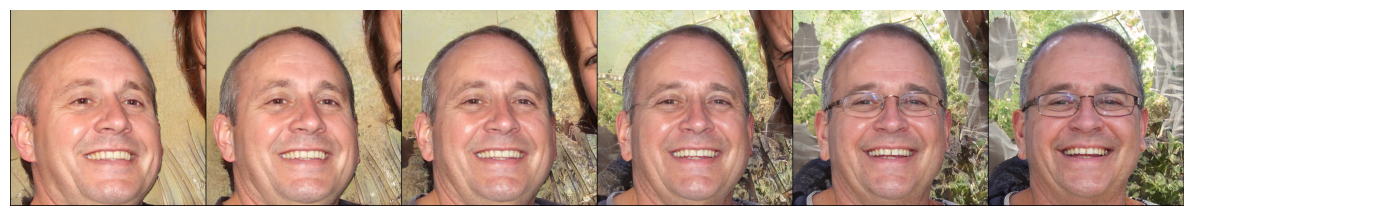

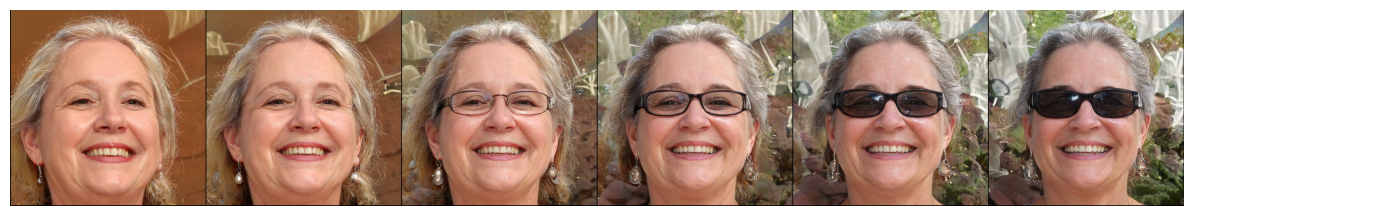

In [ ]:
genders_bool = genders>0.5
for t in [genders_bool,~genders_bool]:
    y_t = _y_t[t]*100
    X_t = _X_t[t]
    traj = torch.zeros([1,7,512],device=device)
    for j,i in enumerate(np.linspace(15,55,7)):
        traj[0,j,:] = X_t[(y_t>i)&(y_t<i+(85-15)/7)].mean(dim=0)
    grid = plot_traj_image_strips(
        G, traj,
        # steps_sel=range(0, 5, 1),            # or e.g. range(0, T+1, 5)
        repeat_layers=18,          # StyleGAN2 W+ layers
        batch_size=16,
        out_size=512,
        show=True,
    ) 

In [ ]:
y_t

tensor([0.1548, 0.1385, 0.1557,  ..., 0.5846, 0.5794, 0.5777], device='mps:0')

# reindex

In [ ]:
#!/usr/bin/env python3
"""
Renumber files named 'j_i.EXT' so that within each i, the j indices are
contiguous starting at 0. Works in-place, keeps extensions, and renames pairs
(e.g., 102_5.jpg and 102_5.pt) consistently.

Usage:
  python renumber_by_second_index.py [directory]        # dry-run (prints plan)
  python renumber_by_second_index.py [directory] --apply  # performs rename
"""

import argparse
import os
import re
import uuid
from collections import defaultdict

FILENAME_RX = re.compile(r'^(\d+)_m_([0-9]+)\.([A-Za-z0-9]+)$')

def collect_entries(dirpath):
    """Return list of (name, j, i, ext) for files matching j_i.EXT."""
    out = []
    for name in os.listdir(dirpath):
        m = FILENAME_RX.match(name)
        if not m:
            continue
        j = int(m.group(1))
        i = int(m.group(2))
        ext = m.group(3)
        ext2 = ''# m.group(4)
        out.append((name, j, i, ext, ext2))
    return out

def build_groups(entries):
    """
    Build:
      - by_key: {(j,i): [filenames with different extensions]}
      - i_to_js: {i: sorted list of unique j's}
    """
    by_key = defaultdict(list)
    i_to_js = defaultdict(set)
    for name, j, i, _ext, _ext2 in entries:
        by_key[(j, i)].append(name)
        i_to_js[i].add(j)
    i_to_js = {i: sorted(js) for i, js in i_to_js.items()}
    return by_key, i_to_js

def plan_moves(dirpath, entries):
    """Create a dict {src_path: dst_path} with desired final names."""
    by_key, i_to_js = build_groups(entries)

    # Map (old_j, i) -> new_j (0..n-1 within each i)
    old_to_new = {}
    for i, js in i_to_js.items():
        for new_j, old_j in enumerate(js):
            old_to_new[(old_j, i)] = new_j

    plan = {}
    for (old_j, i), files in by_key.items():
        new_j = old_to_new[(old_j, i)]
        for name in files:
            # keep original extension
            ext = name.rsplit('.', 1)[1]
            ext2 = name.rsplit('.', 2)[1]
            new_name = f"{new_j}_m_{i}.{ext}"
            src = os.path.join(dirpath, name)
            dst = os.path.join(dirpath, new_name)
            plan[src] = dst
    return plan

def print_plan(plan):
    changed = False
    for src, dst in sorted(plan.items()):
        if os.path.basename(src) != os.path.basename(dst):
            print(f"{os.path.basename(src)}  ->  {os.path.basename(dst)}")
            changed = True
    if not changed:
        print("All files already contiguous by group; nothing to rename.")

def apply_moves_safely(plan):
    """
    Rename via a two-phase temp move to avoid collisions:
      1) src -> uniquely-named temp
      2) temp -> dst
    """
    # Phase 1: move everything to unique temp names
    tmp_map = {}
    for src, dst in plan.items():
        if os.path.basename(src) == os.path.basename(dst):
            continue  # no-op
        tmp = os.path.join(
            os.path.dirname(src),
            f"__tmp__{uuid.uuid4().hex}__{os.path.basename(src)}"
        )
        os.replace(src, tmp)
        tmp_map[tmp] = dst

    # Phase 2: move temps to final names
    for tmp, dst in tmp_map.items():
        final_dst = dst
        if os.path.exists(final_dst):
            # Very unlikely unless there's a conflicting non-batch file.
            base, ext = os.path.splitext(final_dst)
            final_dst = f"{base}__dupe_{uuid.uuid4().hex[:6]}{ext}"
            print(f"Warning: {os.path.basename(dst)} existed; wrote {os.path.basename(final_dst)} instead.")
        os.replace(tmp, final_dst)

def main():
    apply = True
    dirpath = os.path.abspath("/Users/adamsobieszek/PycharmProjects/_manipy/additional_age_faces_filtered_via_feature_distance")
    entries = collect_entries(dirpath)
    if not entries:
        print("No files matching 'j_i.EXT' found.")
        return

    plan = plan_moves(dirpath, entries)
    print_plan(plan)

    if apply:
        apply_moves_safely(plan)
        print("Done.")

if __name__ == "__main__":
    main()

107_m_36.pt  ->  17_m_36.pt
108_m_44.pt  ->  25_m_44.pt
109_m_28.pt  ->  33_m_28.pt
109_m_29.pt  ->  25_m_29.pt
109_m_41.pt  ->  31_m_41.pt
110_m_29.pt  ->  26_m_29.pt
110_m_43.pt  ->  36_m_43.pt
111_m_25.pt  ->  19_m_25.pt
112_m_37.pt  ->  37_m_37.pt
113_m_31.pt  ->  17_m_31.pt
114_m_41.pt  ->  32_m_41.pt
116_m_47.pt  ->  35_m_47.pt
117_m_46.pt  ->  38_m_46.pt
117_m_49.pt  ->  28_m_49.pt
118_m_34.pt  ->  18_m_34.pt
118_m_48.pt  ->  24_m_48.pt
118_m_50.pt  ->  32_m_50.pt
121_m_18.pt  ->  17_m_18.pt
123_m_42.pt  ->  32_m_42.pt
123_m_55.pt  ->  25_m_55.pt
126_m_22.pt  ->  25_m_22.pt
126_m_24.pt  ->  20_m_24.pt
126_m_35.pt  ->  26_m_35.pt
127_m_28.pt  ->  34_m_28.pt
127_m_48.pt  ->  25_m_48.pt
128_m_25.pt  ->  20_m_25.pt
128_m_26.pt  ->  29_m_26.pt
128_m_46.pt  ->  39_m_46.pt
129_m_22.pt  ->  26_m_22.pt
129_m_30.pt  ->  23_m_30.pt
129_m_41.pt  ->  33_m_41.pt
129_m_44.pt  ->  26_m_44.pt
12_m_19.pt  ->  11_m_19.pt
130_m_38.pt  ->  27_m_38.pt
131_m_21.pt  ->  23_m_21.pt
131_m_55.pt  ->  26_m

In [ ]:
from collections import defaultdict
from typing import Dict, List, Tuple

def _bin_key_from_pair(p: ImgPtPair) -> Tuple[str, int]:
    return (p.gender, p.age)

def plan_reindex_per_bin(
    pairs: List[ImgPtPair],
    order_within_bin: str = "old_index",      # "old_index" | "img_mtime" | "pt_mtime" | "filename"
) -> Dict[str, str]:
    """
    Build a mapping old_stem -> new_stem so that within each (gender, age) bin
    the leading index is reassigned to 0..N-1 in a deterministic order.

    The stem format is '{idx}_{gender}_{age}'.
    """
    if not pairs:
        return {}

    # Group by (gender, age)
    groups: Dict[Tuple[str, int], List[ImgPtPair]] = defaultdict(list)
    for p in pairs:
        groups[_bin_key_from_pair(p)].append(p)

    # Sorting key within each bin
    def bin_sort_key(p: ImgPtPair):
        if order_within_bin == "img_mtime":
            try:
                return (os.path.getmtime(p.img_path), p.old_index)
            except Exception:
                return (0.0, p.old_index)
        elif order_within_bin == "pt_mtime":
            try:
                return (os.path.getmtime(p.pt_path), p.old_index)
            except Exception:
                return (0.0, p.old_index)
        elif order_within_bin == "filename":
            return (os.path.basename(p.img_path), p.old_index)
        else:  # "old_index"
            return (p.old_index,)

    mapping: Dict[str, str] = {}

    # Build new stems 0.. within each bin
    for (gender, age), items in groups.items():
        items_sorted = sorted(items, key=bin_sort_key)
        for new_local_idx, p in enumerate(items_sorted):
            old_stem = f"{p.old_index}_{p.gender}_{p.age}"
            new_stem = f"{new_local_idx}_{gender}_{age}"
            mapping[old_stem] = new_stem

    return mapping


def reindex_in_place_per_bin(
    folder: str,
    *,
    order_within_bin: str = "old_index",
    overwrite: bool = False,
    update_pt_payload: bool = True,
    include_preview: bool = True,
    dry_run: bool = False,
) -> Dict[str, Tuple[str, str]]:
    """
    Scan (image, .pt) pairs in `folder`, create a per-bin mapping that resets indices
    to start at 0 in each (gender, age) bin, and apply the rename safely.

    Returns old_stem -> (new_img_path, new_pt_path) for changed files.
    """
    # Find only valid (img, pt) pairs
    pairs = scan_image_pt_pairs(folder, strict_pairs=True)

    # Construct the per-bin mapping
    mapping = plan_reindex_per_bin(pairs, order_within_bin=order_within_bin)

    # Optional preview
    if include_preview:
        bins = sorted(set((p.gender, p.age) for p in pairs))
        print(f"[plan per-bin] bins={len(bins)}, pairs={len(pairs)}, order_within_bin={order_within_bin}")
        sample = list(mapping.items())[:100]
        if sample:
            print("[plan per-bin] first 10:", sample)

    if dry_run:
        print("[dry-run] No files were changed.")
        return {}

    # Apply via your collision-safe two-phase renamer
    result = apply_reindex(
        folder=folder,
        mapping=mapping,
        overwrite=overwrite,
        update_pt_payload=update_pt_payload,
        skip_noop=True,  # ignore stems already correct
    )
    return result

In [ ]:
# 1) Dry-run to preview the plan (no changes)
# reindex_in_place(
#     folder = "/Users/adamsobieszek/PycharmProjects/_manipy/age_oems_img/",

#     start_index=0,                 # new indices will be 0..N-1
#     order="age_gender_old",        # or "old" / "gender_age_old"
#     gender_order=("f", "m"),
#     dry_run=True
# )

# 2) Apply it (renames both .jpg and .pt, and updates the .pt payload)
result = reindex_in_place_per_bin(
    folder = "/Users/adamsobieszek/PycharmProjects/_manipy/additional_age_faces_filtered_via_feature_distance/",
    overwrite=True,               # set True to allow overwriting existing targets
    update_pt_payload=True,
    dry_run=False
)

[plan per-bin] bins=101, pairs=2229, order_within_bin=old_index
[plan per-bin] first 10: [('0_f_7', '0_f_7'), ('1_f_7', '1_f_7'), ('2_f_7', '2_f_7'), ('3_f_7', '3_f_7'), ('4_f_7', '4_f_7'), ('5_f_7', '5_f_7'), ('6_f_7', '6_f_7'), ('7_f_7', '7_f_7'), ('8_f_7', '8_f_7'), ('9_f_7', '9_f_7'), ('10_f_7', '10_f_7'), ('11_f_7', '11_f_7'), ('12_f_7', '12_f_7'), ('13_f_7', '13_f_7'), ('14_f_7', '14_f_7'), ('15_f_7', '15_f_7'), ('16_f_7', '16_f_7'), ('0_f_8', '0_f_8'), ('1_f_8', '1_f_8'), ('2_f_8', '2_f_8'), ('3_f_8', '3_f_8'), ('4_f_8', '4_f_8'), ('5_f_8', '5_f_8'), ('6_f_8', '6_f_8'), ('7_f_8', '7_f_8'), ('8_f_8', '8_f_8'), ('9_f_8', '9_f_8'), ('10_f_8', '10_f_8'), ('11_f_8', '11_f_8'), ('12_f_8', '12_f_8'), ('13_f_8', '13_f_8'), ('14_f_8', '14_f_8'), ('15_f_8', '15_f_8'), ('16_f_8', '16_f_8'), ('17_f_8', '17_f_8'), ('18_f_8', '18_f_8'), ('19_f_8', '19_f_8'), ('20_f_8', '20_f_8'), ('21_f_8', '21_f_8'), ('22_f_8', '22_f_8'), ('23_f_8', '23_f_8'), ('24_f_8', '24_f_8'), ('25_f_8', '25_f_8'), ('0_

In [ ]:
pairs = scan_image_pt_pairs(
    folder="/Users/adamsobieszek/PycharmProjects/_manipy/age_oems_img/",
    strict_pairs=True
)

# Plan while avoiding any non-moving files already in that folder
mapping = plan_reindex(
    pairs,
    start_index=0,
    order="age_gender_old",
)

# (Optional) see what would have blocked you before
blockers = find_reindex_blockers("/Users/adamsobieszek/PycharmProjects/_manipy/age_oems_img/", mapping)
print("[blockers]", blockers[:10])

# Apply (no overwrite needed now)
result = apply_reindex(
    folder="/Users/adamsobieszek/PycharmProjects/_manipy/age_oems_img/",
    mapping=mapping,
    overwrite=False,
    update_pt_payload=True
)

[blockers] ['/Users/adamsobieszek/PycharmProjects/_manipy/age_oems_img/10_f_8.pt', '/Users/adamsobieszek/PycharmProjects/_manipy/age_oems_img/11_f_8.pt', '/Users/adamsobieszek/PycharmProjects/_manipy/age_oems_img/12_f_8.pt', '/Users/adamsobieszek/PycharmProjects/_manipy/age_oems_img/13_f_8.pt', '/Users/adamsobieszek/PycharmProjects/_manipy/age_oems_img/14_f_8.pt', '/Users/adamsobieszek/PycharmProjects/_manipy/age_oems_img/16_f_8.pt', '/Users/adamsobieszek/PycharmProjects/_manipy/age_oems_img/17_f_8.pt', '/Users/adamsobieszek/PycharmProjects/_manipy/age_oems_img/19_f_8.pt', '/Users/adamsobieszek/PycharmProjects/_manipy/age_oems_img/1_f_8.pt', '/Users/adamsobieszek/PycharmProjects/_manipy/age_oems_img/20_f_8.pt']


FileExistsError: Target exists and is not being moved: /Users/adamsobieszek/PycharmProjects/_manipy/age_oems_img/1_f_8.pt. Use overwrite=True or choose a non-colliding start_index.

In [ ]:
# Reset indices to start at 0 within each (gender, age) bin,
# ordered by current index inside each bin.
result = reindex_in_place_per_bin(
    folder="/Users/adamsobieszek/PycharmProjects/_manipy/age_oems_img/",
    order_within_bin="old_index",   # or "img_mtime" / "pt_mtime" / "filename"
    overwrite=True,                # set True if you know there are stray files blocking targets
    update_pt_payload=True,
    dry_run=False
)

[plan per-bin] bins=64, pairs=2586
[plan per-bin] first 10: [('0_f_8', '0_f_8'), ('2_f_8', '1_f_8'), ('3_f_8', '2_f_8'), ('6_f_8', '3_f_8'), ('7_f_8', '4_f_8'), ('9_f_8', '5_f_8'), ('15_f_8', '6_f_8'), ('18_f_8', '7_f_8'), ('22_f_8', '8_f_8'), ('23_f_8', '9_f_8')]


In [ ]:
# Reset indices to start at 0 within each (gender, age) bin,
# ordered by current index inside each bin.
result = reindex_in_place_per_bin(
    folder="/Users/adamsobieszek/PycharmProjects/_manipy/content/out_filtered3",
    order_within_bin="old_index",   # or "img_mtime" / "pt_mtime" / "filename"
    overwrite=True,                # set True if you know there are stray files blocking targets
    update_pt_payload=False,
    dry_run=False
)

[plan per-bin] bins=0, pairs=0
